In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [34]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='white'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

# <span style="color:red">Importing Data Sets and Masks</span>

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

In [3]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


In [4]:
gfdl_esm4_precip_data = google_cloud_cmip6.query(
    # "activity_id=='ScenarioMIP' & \
    "table_id == 'Amon' & \
    variable_id == 'prsn' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")
     

In [5]:
gfdl_cm4_precip_data = google_cloud_cmip6.query(
    #"activity_id=='ScenarioMIP' & \
    "table_id == 'Amon' & \
    variable_id == 'prsn' & \
    experiment_id == 'piControl' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-CM4'"
)

In [6]:
ERA5_snowfall_data= xr.open_mfdataset('/home/tu.temple.edu/tuo59681/era5/snowfall_ensemble/era5_mean_snowfall_rate_1940-2024_monthly_ensemble.nc')


In [7]:
ERA5_snowfall_data

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 361, number: 10, expver: 2, time: 1013)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-05-01
Data variables:
    msr        (time, expver, number, latitude, longitude) float32 dask.array<chunksize=(1013, 2, 10, 361, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-18 22:02:00 UTC by era5cli 1.4.2: reanalysis-era5-s...

In [8]:
ERA5_snowfall= ERA5_snowfall_data.msr

In [9]:
ERA5_snowfall

<xarray.DataArray 'msr' (time: 1013, expver: 2, number: 10, latitude: 361,
                         longitude: 720)>
dask.array<open_dataset-msr, shape=(1013, 2, 10, 361, 720), dtype=float32, chunksize=(1013, 2, 10, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-05-01
Attributes:
    units:      kg m**-2 s**-1
    long_name:  Mean snowfall rate

In [10]:
#combining the expver 1 and 5 values into one data set to remove the dimension
ERA5_combine =ERA5_snowfall.sel(expver=1).combine_first(ERA5_snowfall.sel(expver=5))
ERA5_combine.load()

<xarray.DataArray 'msr' (time: 1013, number: 10, latitude: 361, longitude: 720)>
array([[[[4.6868518e-06, 4.6868518e-06, 4.6868518e-06, ...,
          4.6868518e-06, 4.6868518e-06, 4.6868518e-06],
         [5.2065589e-06, 5.2160904e-06, 5.2208634e-06, ...,
          5.1922543e-06, 5.2017858e-06, 5.2065589e-06],
         [5.7834695e-06, 5.7930010e-06, 5.8025471e-06, ...,
          5.7501020e-06, 5.7596335e-06, 5.7643920e-06],
         ...,
         [1.3731624e-06, 1.3731624e-06, 1.3779354e-06, ...,
          1.3731624e-06, 1.3731624e-06, 1.3731624e-06],
         [1.4017714e-06, 1.4017714e-06, 1.4065299e-06, ...,
          1.4017714e-06, 1.4017714e-06, 1.4017714e-06],
         [1.6353879e-06, 1.6353879e-06, 1.6353879e-06, ...,
          1.6353879e-06, 1.6353879e-06, 1.6353879e-06]],

        [[2.3076718e-06, 2.3076718e-06, 2.3076718e-06, ...,
          2.3076718e-06, 2.3076718e-06, 2.3076718e-06],
         [2.6271155e-06, 2.6318885e-06, 2.6366615e-06, ...,
          2.6080525e-06, 2.6128109e-06, 2.6223570e-06],
         [2.9561052e-06, 2.9704097e-06, 2.9799412e-06, ...,
          2.9131916e-06, 2.9274961e-06, 2.9370276e-06],
...
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04]],

        [[1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         ...,
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04],
         [1.5622511e-04, 1.5622511e-04, 1.5622511e-04, ...,
          1.5622511e-04, 1.5622511e-04, 1.5622511e-04]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-05-01
Attributes:
    units:      kg m**-2 s**-1
    long_name:  Mean snowfall rate

In [11]:
#meaning number to remove the dimension and slicing time to be the same as the paper
ERA5_snowfall_amount= ERA5_combine.mean('number').sel(time=slice('1979-01-01','2018-12-01'))

In [12]:

gfdl_esm4_precip_data

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
18372,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Amon,prsn,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701


In [13]:
gfdl_cm4_precip_data

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9379,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,prsn,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701


In [14]:
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = gfdl_cm4_precip_data.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

precip_cm4 = xr.open_zarr(mapper, consolidated=True)
precip_cm4

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 6000)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Data variables:
    prsn       (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    ...                     ...
    variable_id:            prsn
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-08;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/32c9c5c3-b30a-4c23-9891-991a7f505bc9...
    version_id:             v20180701

In [15]:
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = gfdl_esm4_precip_data.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

precip_esm4 = xr.open_zarr(mapper, consolidated=True)
precip_esm4

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 6000)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0001-01-16 12:00:00 ... 0500-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Data variables:
    prsn       (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          Coupled climate state after 400 years of spinup, ...
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                <null ref>
    ...                     ...
    variable_id:            prsn
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/d6e78fca-2eb2-4259-ab7e-6182baf66e7b...
    version_id:             v20180701

In [16]:
#selecting precip variable
ESM4_prsn= precip_esm4.prsn
CM4_prsn=precip_cm4.prsn

# <span style="color:red">Calculating Seconds for Unit Conversions to Get to mm</span>

In [17]:
#calculating monthly seconds to convert precip units and getting annual and seasonal seconds
jan_sec=2678400
feb_sec=2419200
mar_sec=2678400
apr_sec=2592000
may_sec=2678400
jun_sec=2592000
jul_sec=2678400
aug_sec=2678400
sep_sec=2592000
oct_sec=2678400
nov_sec=2592000
dec_sec=2678400
ann_sec=jan_sec+feb_sec+mar_sec+apr_sec+may_sec+jun_sec+jul_sec+aug_sec+sep_sec+oct_sec+nov_sec+dec_sec
DJF_sec= dec_sec+jan_sec+feb_sec
JJA_sec= jun_sec+jul_sec+aug_sec
SON_sec = sep_sec+oct_sec+nov_sec
MAM_sec= mar_sec+apr_sec+may_sec

# <span style="color:red">Seasonal Slices- Created seasonal slices for each data set to compare seasonal precipitation</span>

In [18]:
precip_seasonal_CM4 = CM4_prsn.groupby('time.season').mean(dim='time')
precip_summer_CM4= precip_seasonal_CM4.sel(season= 'DJF')
precip_winter_CM4=precip_seasonal_CM4.sel(season='JJA')
precip_spring_CM4=precip_seasonal_CM4.sel(season='SON')
precip_fall_CM4=precip_seasonal_CM4.sel(season='MAM')

In [19]:
precip_seasonal_ESM4 = ESM4_prsn.groupby('time.season').mean(dim='time')
precip_summer_ESM4= precip_seasonal_ESM4.sel(season= 'DJF')
precip_winter_ESM4=precip_seasonal_ESM4.sel(season='JJA')
precip_spring_ESM4=precip_seasonal_ESM4.sel(season='SON')
precip_fall_ESM4=precip_seasonal_ESM4.sel(season='MAM')

In [20]:
precip_seasonal_ERA5 = ERA5_snowfall_amount.groupby('time.season').mean(dim='time')
precip_summer_ERA5= precip_seasonal_ERA5.sel(season= 'DJF')
precip_winter_ERA5=precip_seasonal_ERA5.sel(season='JJA')
precip_spring_ERA5=precip_seasonal_ERA5.sel(season='SON')
precip_fall_ERA5=precip_seasonal_ERA5.sel(season='MAM')

In [21]:
precip_total_CM4=CM4_prsn.mean('time')
precip_total_ESM4=ESM4_prsn.mean('time')
precip_total_ERA5=ERA5_snowfall_amount.mean('time')

# <span style="color:red">Applying Masks- Multiplied by annual seconds to convert to mm of precip from Kg/m^2 s</span>

Unit= Kg/m^2 s / 1000Kg/m^3 x 1000mm x seconds= mm

In [22]:

plateau_precip_CM4_bar=((precip_total_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon'))*(ann_sec)
ross_precip_CM4_bar=((precip_total_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon'))*(ann_sec)
lowwest_precip_CM4_bar=((precip_total_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon'))*(ann_sec)
loweast_precip_CM4_bar=((precip_total_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon'))*(ann_sec)
filchner_precip_CM4_bar=((precip_total_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon'))*(ann_sec)
peninsula_precip_CM4_bar=((precip_total_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon'))*(ann_sec)

plateau_precip_ESM4_bar=((precip_total_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon'))*(ann_sec)
ross_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*(ann_sec)
lowwest_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*(ann_sec)
loweast_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*(ann_sec)
filchner_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*(ann_sec)
peninsula_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*(ann_sec)

plateau_precip_ERA5_bar=((precip_total_ERA5*(mask_ERA5.plateau_ERA5)).mean('latitude').mean('longitude'))*(ann_sec)
ross_precip_ERA5_bar=(precip_total_ERA5*(mask_ERA5.ross_ERA5)).mean('latitude').mean('longitude')*(ann_sec)
lowwest_precip_ERA5_bar=(precip_total_ERA5*(mask_ERA5.lowwest_ERA5)).mean('latitude').mean('longitude')*(ann_sec)
loweast_precip_ERA5_bar=(precip_total_ERA5*(mask_ERA5.loweast_ERA5)).mean('latitude').mean('longitude')*(ann_sec)
filchner_precip_ERA5_bar=(precip_total_ERA5*(mask_ERA5.filchner_ERA5)).mean('latitude').mean('longitude')*(ann_sec)
peninsula_precip_ERA5_bar=(precip_total_ERA5*(mask_ERA5.peninsula_ERA5)).mean('latitude').mean('longitude')*(ann_sec)

In [31]:
plateau_precip_summer_CM4=(precip_summer_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon')*DJF_sec
ross_precip_summer_CM4=(precip_summer_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon')*DJF_sec
lowwest_precip_summer_CM4=(precip_summer_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon')*DJF_sec
loweast_precip_summer_CM4=(precip_summer_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon')*DJF_sec
filchner_precip_summer_CM4=(precip_summer_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon')*DJF_sec
peninsula_precip_summer_CM4=(precip_summer_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon')*DJF_sec

plateau_precip_summer_ESM4=(precip_summer_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon')*DJF_sec
ross_precip_summer_ESM4=(precip_summer_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*DJF_sec
lowwest_precip_summer_ESM4=(precip_summer_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*DJF_sec
loweast_precip_summer_ESM4=(precip_summer_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*DJF_sec
filchner_precip_summer_ESM4=(precip_summer_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*DJF_sec
peninsula_precip_summer_ESM4=(precip_summer_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*DJF_sec

plateau_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.plateau_ERA5)).mean('latitude').mean('longitude')*DJF_sec
ross_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.ross_ERA5)).mean('latitude').mean('longitude')*DJF_sec
lowwest_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.lowwest_ERA5)).mean('latitude').mean('longitude')*DJF_sec
loweast_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.loweast_ERA5)).mean('latitude').mean('longitude')*DJF_sec
filchner_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.filchner_ERA5)).mean('latitude').mean('longitude')*DJF_sec
peninsula_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.peninsula_ERA5)).mean('latitude').mean('longitude')*DJF_sec

In [32]:
plateau_precip_winter_CM4=(precip_winter_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon')*JJA_sec
ross_precip_winter_CM4=(precip_winter_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon')*JJA_sec
lowwest_precip_winter_CM4=(precip_winter_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon')*JJA_sec
loweast_precip_winter_CM4=(precip_winter_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon')*JJA_sec
filchner_precip_winter_CM4=(precip_winter_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon')*JJA_sec
peninsula_precip_winter_CM4=(precip_winter_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon')*JJA_sec

plateau_precip_winter_ESM4=(precip_winter_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon')*JJA_sec
ross_precip_winter_ESM4=(precip_winter_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*JJA_sec
lowwest_precip_winter_ESM4=(precip_winter_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*JJA_sec
loweast_precip_winter_ESM4=(precip_winter_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*JJA_sec
filchner_precip_winter_ESM4=(precip_winter_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*JJA_sec
peninsula_precip_winter_ESM4=(precip_winter_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*JJA_sec

plateau_precip_winter_ERA5=(precip_winter_ERA5*(mask_ERA5.plateau_ERA5)).mean('latitude').mean('longitude')*JJA_sec
ross_precip_winter_ERA5=(precip_winter_ERA5*(mask_ERA5.ross_ERA5)).mean('latitude').mean('longitude')*JJA_sec
lowwest_precip_winter_ERA5=(precip_winter_ERA5*(mask_ERA5.lowwest_ERA5)).mean('latitude').mean('longitude')*JJA_sec
loweast_precip_winter_ERA5=(precip_winter_ERA5*(mask_ERA5.loweast_ERA5)).mean('latitude').mean('longitude')*JJA_sec
filchner_precip_winter_ERA5=(precip_winter_ERA5*(mask_ERA5.filchner_ERA5)).mean('latitude').mean('longitude')*JJA_sec
peninsula_precip_winter_ERA5=(precip_winter_ERA5*(mask_ERA5.peninsula_ERA5)).mean('latitude').mean('longitude')*JJA_sec

In [33]:
plateau_precip_spring_CM4=(precip_spring_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon')*SON_sec
ross_precip_spring_CM4=(precip_spring_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon')*SON_sec
lowwest_precip_spring_CM4=(precip_spring_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon')*SON_sec
loweast_precip_spring_CM4=(precip_spring_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon')*SON_sec
filchner_precip_spring_CM4=(precip_spring_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon')*SON_sec
peninsula_precip_spring_CM4=(precip_spring_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon')*SON_sec

plateau_precip_spring_ESM4=(precip_spring_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon')*SON_sec
ross_precip_spring_ESM4=(precip_spring_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*SON_sec
lowwest_precip_spring_ESM4=(precip_spring_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*SON_sec
loweast_precip_spring_ESM4=(precip_spring_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*SON_sec
filchner_precip_spring_ESM4=(precip_spring_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*SON_sec
peninsula_precip_spring_ESM4=(precip_spring_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*SON_sec

plateau_precip_spring_ERA5=(precip_spring_ERA5*(mask_ERA5.plateau_ERA5)).mean('latitude').mean('longitude')*SON_sec
ross_precip_spring_ERA5=(precip_spring_ERA5*(mask_ERA5.ross_ERA5)).mean('latitude').mean('longitude')*SON_sec
lowwest_precip_spring_ERA5=(precip_spring_ERA5*(mask_ERA5.lowwest_ERA5)).mean('latitude').mean('longitude')*SON_sec
loweast_precip_spring_ERA5=(precip_spring_ERA5*(mask_ERA5.loweast_ERA5)).mean('latitude').mean('longitude')*SON_sec
filchner_precip_spring_ERA5=(precip_spring_ERA5*(mask_ERA5.filchner_ERA5)).mean('latitude').mean('longitude')*SON_sec
peninsula_precip_spring_ERA5=(precip_spring_ERA5*(mask_ERA5.peninsula_ERA5)).mean('latitude').mean('longitude')*SON_sec

In [34]:
plateau_precip_fall_CM4=(precip_fall_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon')*MAM_sec
ross_precip_fall_CM4=(precip_fall_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon')*MAM_sec
lowwest_precip_fall_CM4=(precip_fall_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon')*MAM_sec
loweast_precip_fall_CM4=(precip_fall_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon')*MAM_sec
filchner_precip_fall_CM4=(precip_fall_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon')*MAM_sec
peninsula_precip_fall_CM4=(precip_fall_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon')*MAM_sec

plateau_precip_fall_ESM4=(precip_fall_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon')*MAM_sec
ross_precip_fall_ESM4=(precip_fall_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*MAM_sec
lowwest_precip_fall_ESM4=(precip_fall_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*MAM_sec
loweast_precip_fall_ESM4=(precip_fall_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*MAM_sec
filchner_precip_fall_ESM4=(precip_fall_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*MAM_sec
peninsula_precip_fall_ESM4=(precip_fall_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*MAM_sec

plateau_precip_fall_ERA5=(precip_fall_ERA5*(mask_ERA5.plateau_ERA5)).mean('latitude').mean('longitude')*MAM_sec
ross_precip_fall_ERA5=(precip_fall_ERA5*(mask_ERA5.ross_ERA5)).mean('latitude').mean('longitude')*MAM_sec
lowwest_precip_fall_ERA5=(precip_fall_ERA5*(mask_ERA5.lowwest_ERA5)).mean('latitude').mean('longitude')*MAM_sec
loweast_precip_fall_ERA5=(precip_fall_ERA5*(mask_ERA5.loweast_ERA5)).mean('latitude').mean('longitude')*MAM_sec
filchner_precip_fall_ERA5=(precip_fall_ERA5*(mask_ERA5.filchner_ERA5)).mean('latitude').mean('longitude')*MAM_sec
peninsula_precip_fall_ERA5=(precip_fall_ERA5*(mask_ERA5.peninsula_ERA5)).mean('latitude').mean('longitude')*MAM_sec

# <span style="color:red">Spatial Plots</span>

In [32]:
plateau_precip_CM4_spatial=((precip_total_CM4*(mask_CM4.plateau_CM4)*(ann_sec)))
ross_precip_CM4_spatial=((precip_total_CM4*(mask_CM4.ross_CM4))*(ann_sec))
lowwest_precip_CM4_spatial=((precip_total_CM4*(mask_CM4.lowwest_CM4))*(ann_sec))
loweast_precip_CM4_spatial=((precip_total_CM4*(mask_CM4.loweast_CM4))*(ann_sec))
filchner_precip_CM4_spatial=((precip_total_CM4*(mask_CM4.filchner_CM4))*(ann_sec))
peninsula_precip_CM4_spatial=((precip_total_CM4*(mask_CM4.peninsula_CM4))*(ann_sec))

plateau_precip_ESM4_spatial=((precip_total_ESM4*(mask_ESM4.plateau_ESM4))*(ann_sec))
ross_precip_ESM4_spatial=(precip_total_ESM4*(mask_ESM4.ross_ESM4))*(ann_sec)
lowwest_precip_ESM4_spatial=(precip_total_ESM4*(mask_ESM4.lowwest_ESM4))*(ann_sec)
loweast_precip_ESM4_spatial=(precip_total_ESM4*(mask_ESM4.loweast_ESM4))*(ann_sec)
filchner_precip_ESM4_spatial=(precip_total_ESM4*(mask_ESM4.filchner_ESM4))*(ann_sec)
peninsula_precip_ESM4_spatial=(precip_total_ESM4*(mask_ESM4.peninsula_ESM4))*(ann_sec)

plateau_precip_ERA5_spatial=((precip_total_ERA5*(mask_ERA5.plateau_ERA5))*(ann_sec))
ross_precip_ERA5_spatial=(precip_total_ERA5*(mask_ERA5.ross_ERA5))*(ann_sec)
lowwest_precip_ERA5_spatial=(precip_total_ERA5*(mask_ERA5.lowwest_ERA5))*(ann_sec)
loweast_precip_ERA5_spatial=(precip_total_ERA5*(mask_ERA5.loweast_ERA5))*(ann_sec)
filchner_precip_ERA5_spatial=(precip_total_ERA5*(mask_ERA5.filchner_ERA5))*(ann_sec)
peninsula_precip_ERA5_spatial=(precip_total_ERA5*(mask_ERA5.peninsula_ERA5))*(ann_sec)

In [ ]:
plateau_precip_summer_CM4_spatial=(precip_summer_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon')*DJF_sec
ross_precip_summer_CM4_spatial=(precip_summer_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon')*DJF_sec
lowwest_precip_summer_CM4_spatial=(precip_summer_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon')*DJF_sec
loweast_precip_summer_CM4_spatial=(precip_summer_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon')*DJF_sec
filchner_precip_summer_CM4_spatial=(precip_summer_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon')*DJF_sec
peninsula_precip_summer_CM4_spatial=(precip_summer_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon')*DJF_sec

plateau_precip_summer_ESM4_spatial=(precip_summer_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon')*DJF_sec
ross_precip_summer_ESM4_spatial=(precip_summer_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*DJF_sec
lowwest_precip_summer_ESM4_spatial=(precip_summer_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*DJF_sec
loweast_precip_summer_ESM4_spatial=(precip_summer_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*DJF_sec
filchner_precip_summer_ESM4_spatial=(precip_summer_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*DJF_sec
peninsula_precip_summer_ESM4_spatial=(precip_summer_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*DJF_sec

plateau_precip_summer_ERA5_spatial=(precip_summer_ERA5*(mask_ERA5.plateau_ERA5)).mean('latitude').mean('longitude')*DJF_sec
ross_precip_summer_ERA5_spatial=(precip_summer_ERA5*(mask_ERA5.ross_ERA5)).mean('latitude').mean('longitude')*DJF_sec
lowwest_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.lowwest_ERA5)).mean('latitude').mean('longitude')*DJF_sec
loweast_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.loweast_ERA5)).mean('latitude').mean('longitude')*DJF_sec
filchner_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.filchner_ERA5)).mean('latitude').mean('longitude')*DJF_sec
peninsula_precip_summer_ERA5=(precip_summer_ERA5*(mask_ERA5.peninsula_ERA5)).mean('latitude').mean('longitude')*DJF_sec

Text(0.5, 0.98, 'Precipitation (mm)')

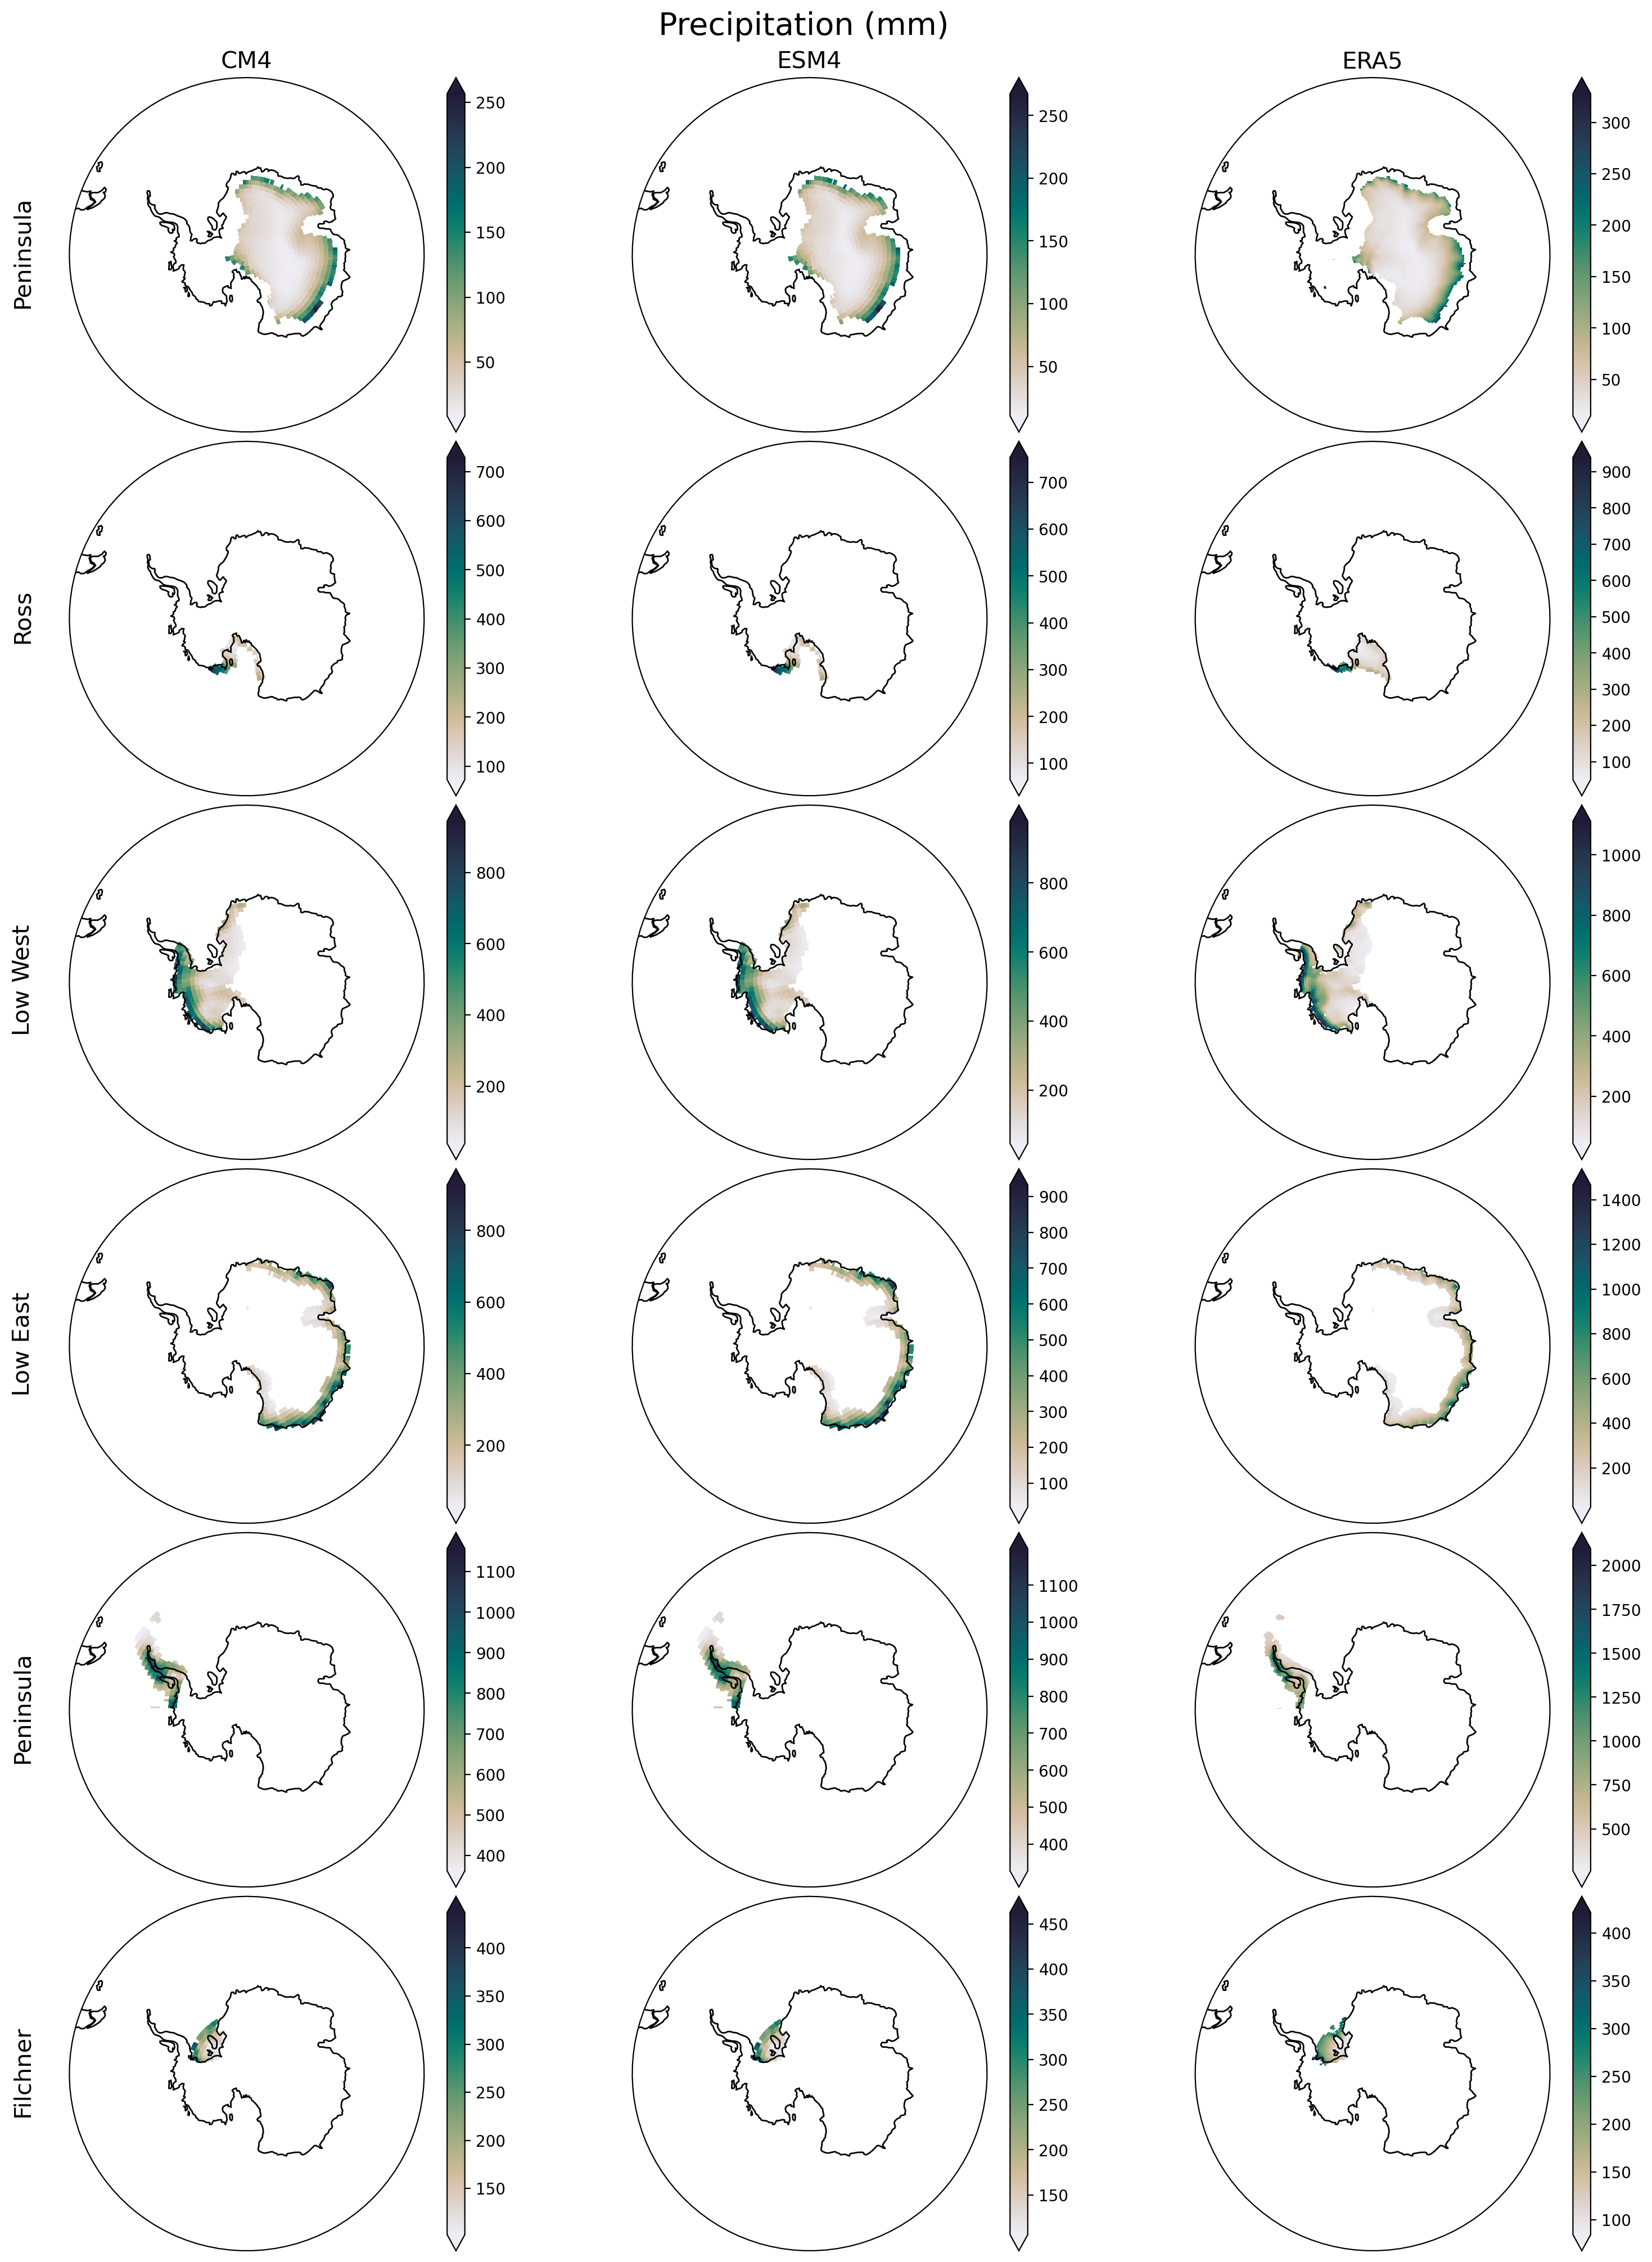

In [48]:
fig, ax = south_pole_map(cols=3, rows=6,fig_size=(15,20))



#CM4 Plots
plateau_precip_CM4_spatial.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.rain)
    
ross_precip_CM4_spatial.plot(ax=ax[1,0],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.rain)
lowwest_precip_CM4_spatial.plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.rain)
    
loweast_precip_CM4_spatial.plot(ax=ax[3,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.rain)
peninsula_precip_CM4_spatial.plot(ax=ax[4,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.rain)
filchner_precip_CM4_spatial.plot(ax=ax[5,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.rain)
#ESM4 Plots

plateau_precip_ESM4_spatial.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.rain)
    
ross_precip_ESM4_spatial.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.rain)
lowwest_precip_ESM4_spatial.plot(ax=ax[2,1],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.rain)
    
loweast_precip_ESM4_spatial.plot(ax=ax[3,1],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.rain)
peninsula_precip_ESM4_spatial.plot(ax=ax[4,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.rain)
filchner_precip_ESM4_spatial.plot(ax=ax[5,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.rain)

#ERA5 Plots
plateau_precip_ERA5_spatial.plot(ax=ax[0,2],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.rain)
    
ross_precip_ERA5_spatial.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.rain)
lowwest_precip_ERA5_spatial.plot(ax=ax[2,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.rain)
    
loweast_precip_ERA5_spatial.plot(ax=ax[3,2],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.rain)
peninsula_precip_ERA5_spatial.plot(ax=ax[4,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.rain)
filchner_precip_ERA5_spatial.plot(ax=ax[5,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.rain)
ax[0,0].coastlines()
ax[1,0].coastlines()
ax[2,0].coastlines()
ax[3,0].coastlines()
ax[4,0].coastlines()
ax[5,0].coastlines()

ax[0,1].coastlines()
ax[1,1].coastlines()
ax[2,1].coastlines()
ax[3,1].coastlines()
ax[4,1].coastlines()
ax[5,1].coastlines()

ax[0,2].coastlines()
ax[1,2].coastlines()
ax[2,2].coastlines()
ax[3,2].coastlines()
ax[4,2].coastlines()
ax[5,2].coastlines()


ax[0,0].set_title('CM4',size=15)
ax[0,1].set_title('ESM4',size=15)
ax[0,2].set_title('ERA5',size=15)
ax[1,2].set_title('')
ax[2,2].set_title('')
ax[3,2].set_title('')
ax[4,2].set_title('')
ax[5,2].set_title('')
rows = ['Peninsula', 'Ross', 'Low West', 'Low East', 'Peninsula', 'Filchner']

for ax, row in zip(ax[:,0], rows):
    ax.annotate(row, xy=(-30, 115), 
                xycoords='axes points', ha='center', va='center', color='k', rotation=90, fontsize=15)

fig.suptitle('Precipitation (mm)', fontsize=20)

# <span style="color:red">Total Precip Plot</span>

In [35]:
plat_value_CM4=print(plateau_precip_CM4_bar.values)
ross_value_CM4= print(ross_precip_CM4_bar.values)
west_value_CM4=print(lowwest_precip_CM4_bar.values)
east_value_CM4=print(loweast_precip_CM4_bar.values)
filch_value_CM4=print(filchner_precip_CM4_bar.values)
pen_value_CM4=print(peninsula_precip_CM4_bar.values)

49.61403226661787
190.57989917200757
182.34430035226978
263.89071535959374
183.51869201433146
612.723630387336


In [36]:
plat_value_ESM4=print(plateau_precip_ESM4_bar.values)
ross_value_ESM4= print(ross_precip_ESM4_bar.values)
west_value_ESM4=print(lowwest_precip_ESM4_bar.values)
east_value_ESM4=print(loweast_precip_ESM4_bar.values)
filch_value_ESM4=print(filchner_precip_ESM4_bar.values)
pen_value_ESM4=print(peninsula_precip_ESM4_bar.values)

55.80520853254711
191.8086715741083
190.1438924105605
287.2772730770521
193.41247317788657
619.1086061589886


In [37]:
plat_value_ERA5=print(plateau_precip_ERA5_bar.values)
ross_value_ERA5= print(ross_precip_ERA5_bar.values)
west_value_ERA5=print(lowwest_precip_ERA5_bar.values)
east_value_ERA5=print(loweast_precip_ERA5_bar.values)
filch_value_ERA5=print(filchner_precip_ERA5_bar.values)
pen_value_ERA5=print(peninsula_precip_ERA5_bar.values)

62.39680100043188
234.10986027738545
192.50617053330643
290.77986885386053
195.98141819005832
741.9004318944644


(0.0, 900.0)

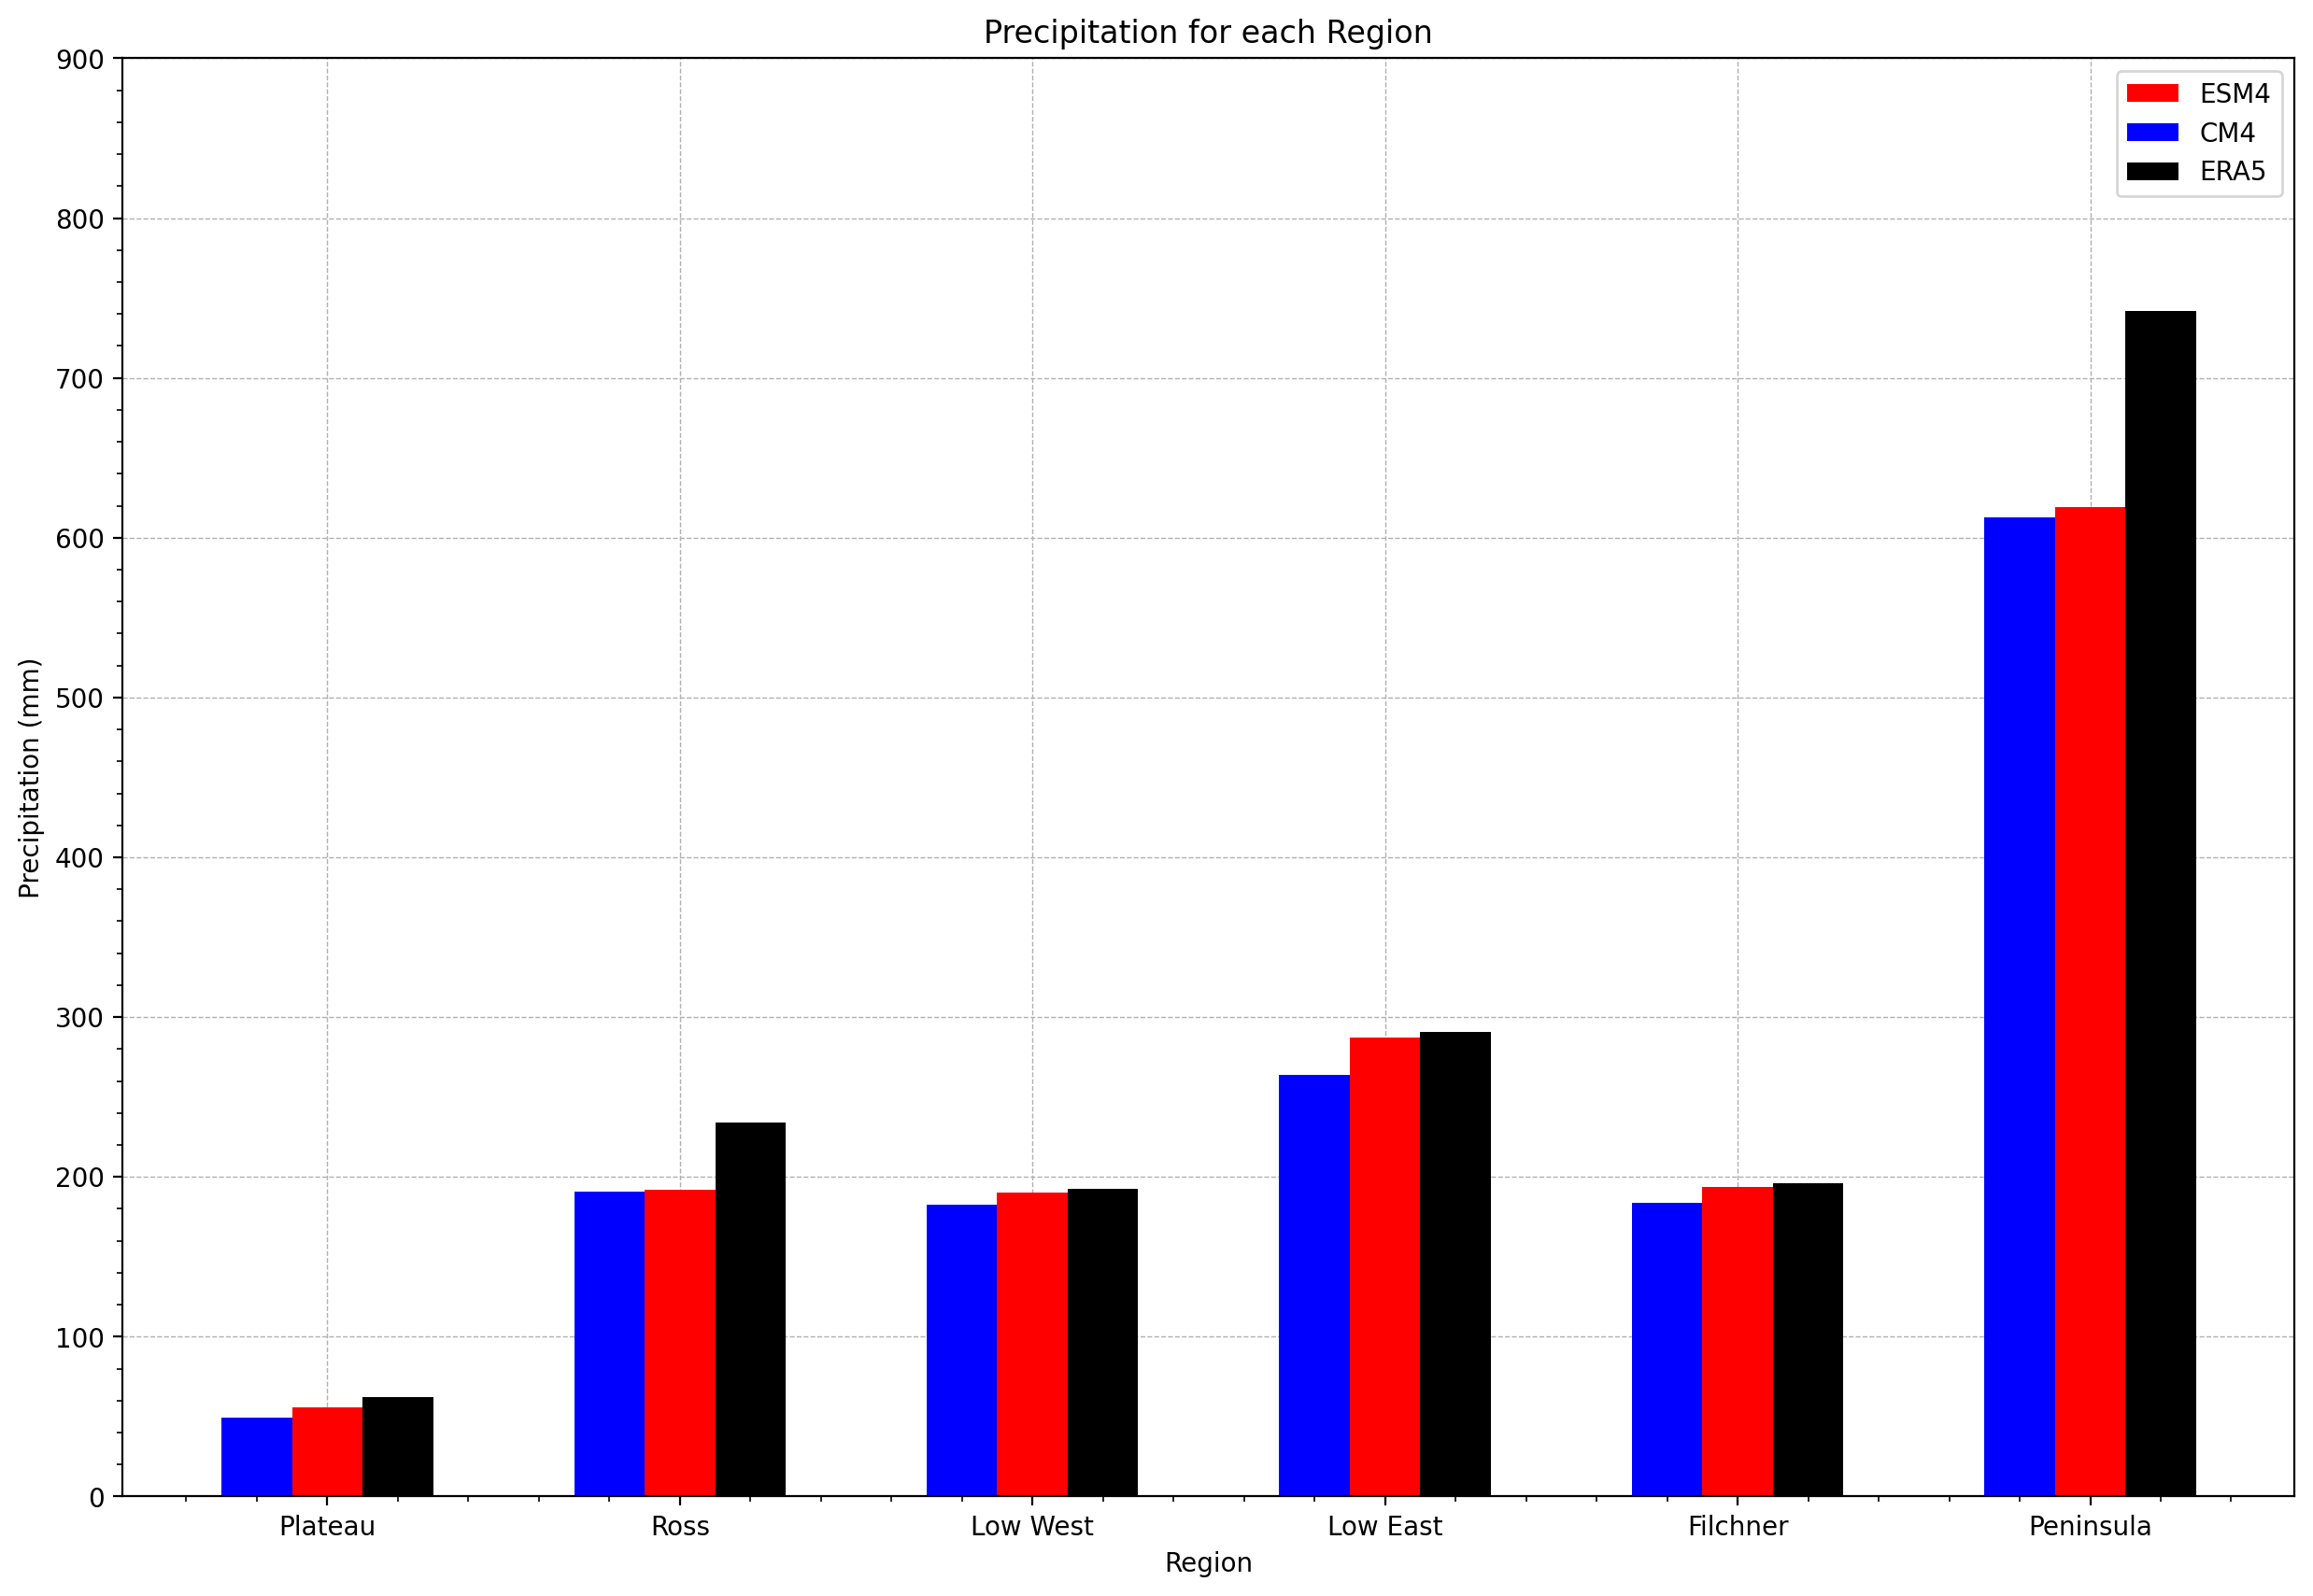

In [38]:

fig, ax= plt.subplots(figsize= (15,10))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_total = [49.61403226661787,
190.57989917200757,
182.34430035226978,
263.89071535959374,
183.51869201433146,
612.723630387336] 
ESM4_total = [55.80520853254711,
191.8086715741083,
190.1438924105605,
287.2772730770521,
193.41247317788657,
619.1086061589886] 

ERA5_total = [62.39680100043188,
234.10986027738545,
192.50617053330643,
290.77986885386053,
195.98141819005832,
741.9004318944644]
  
X_axis = np.arange(len(X)) 
plt.bar(X_axis, ESM4_total, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_total, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_total, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Precipitation (mm)" )
plt.title("Precipitation for each Region") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,900)


# <span style="color:red">Summer Temp Plot</span>

In [39]:
plat_value_CM4_summer=print(plateau_precip_summer_CM4.values)
ross_value_CM4_summer= print(ross_precip_summer_CM4.values)
west_value_CM4_summer=print(lowwest_precip_summer_CM4.values)
east_value_CM4_summer=print(loweast_precip_summer_CM4.values)
filch_value_CM4_summer=print(filchner_precip_summer_CM4.values)
pen_value_CM4_summer=print(peninsula_precip_summer_CM4.values)

10.822608273883816
53.18201224145014
42.626605223631486
58.57381381792948
32.05118025653064
89.50323925819248


In [40]:
plat_value_ESM4_summer=print(plateau_precip_summer_ESM4.values)
ross_value_ESM4_summer= print(ross_precip_summer_ESM4.values)
west_value_ESM4_summer=print(lowwest_precip_summer_ESM4.values)
east_value_ESM4_summer=print(loweast_precip_summer_ESM4.values)
filch_value_ESM4_summer=print(filchner_precip_summer_ESM4.values)
pen_value_ESM4_summer=print(peninsula_precip_summer_ESM4.values)

12.789219737896929
48.24368210393004
41.81621951283887
61.23524985741824
32.56126843916718
93.61944024567492


In [41]:
plat_value_ERA5_summer=print(plateau_precip_summer_ERA5.values)
ross_value_ERA5_summer= print(ross_precip_summer_ERA5.values)
west_value_ERA5_summer=print(lowwest_precip_summer_ERA5.values)
east_value_ERA5_summer=print(loweast_precip_summer_ERA5.values)
filch_value_ERA5_summer=print(filchner_precip_summer_ERA5.values)
pen_value_ERA5_summer=print(peninsula_precip_summer_ERA5.values)

11.804964116890915
45.126465542125516
35.33478519238997
62.02709217905067
41.39255752670579
126.93997984752059


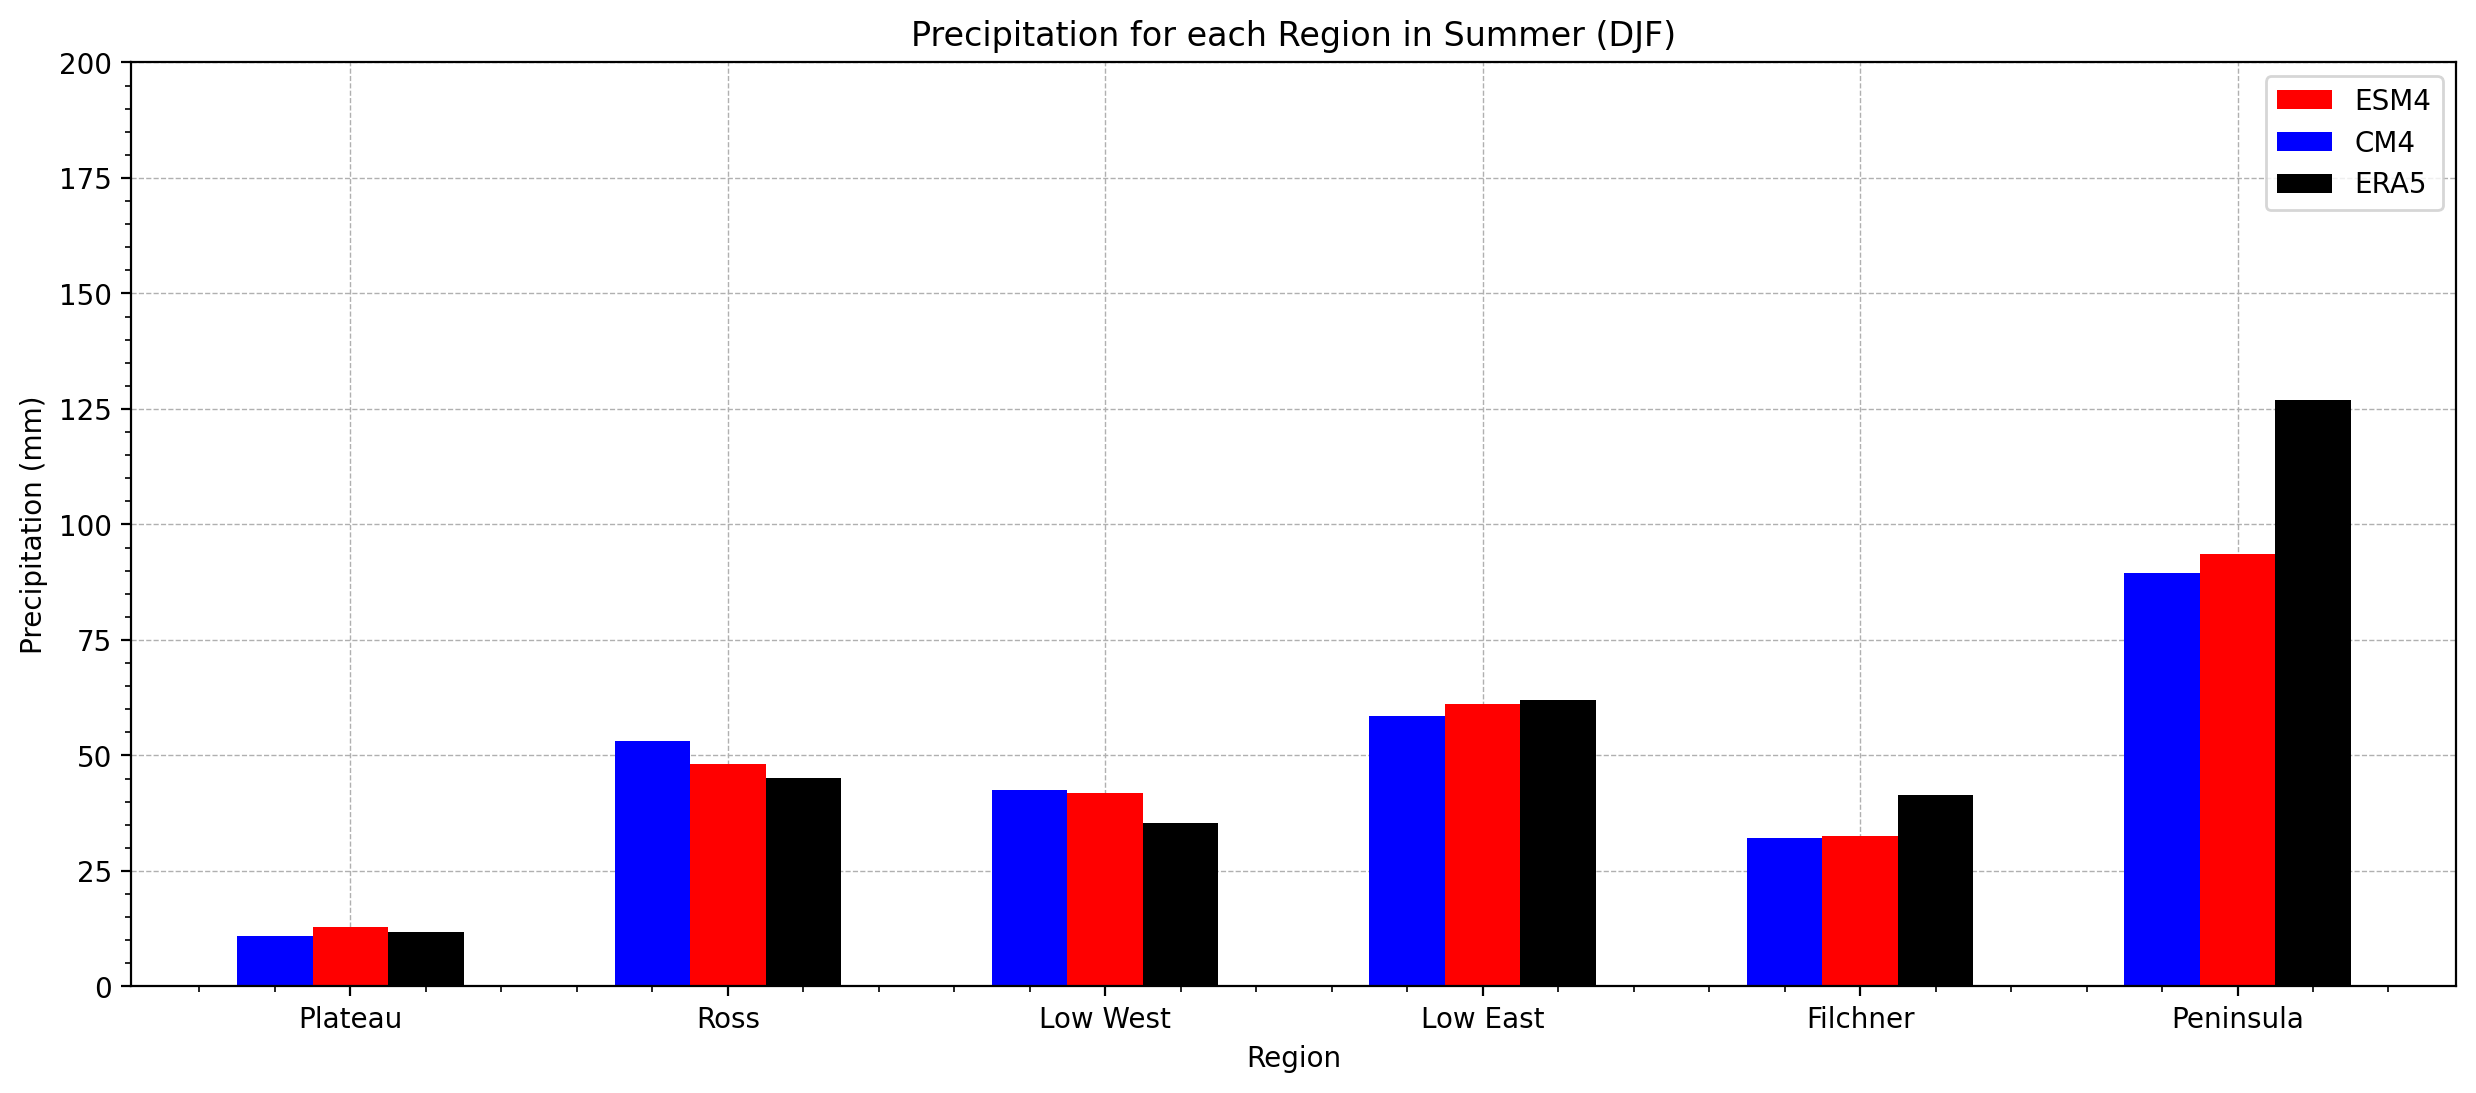

In [42]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_summer = [10.822608273883816,
53.18201224145014,
42.626605223631486,
58.57381381792948,
32.05118025653064,
89.50323925819248

] 
ESM4_summer = [12.789219737896929,
48.24368210393004,
41.81621951283887,
61.23524985741824,
32.56126843916718,
93.61944024567492
] 

ERA5_summer = [11.804964116890915,
45.126465542125516,
35.33478519238997,
62.02709217905067,
41.39255752670579,
126.93997984752059
       ]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_summer, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_summer, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_summer, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Precipitation (mm)") 
plt.title("Precipitation for each Region in Summer (DJF)") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,200)
plt.show() 








# <span style="color:red">Winter Temp Plot</span>

In [43]:
plat_value_CM4_winter=print(plateau_precip_winter_CM4.values)
ross_value_CM4_winter= print(ross_precip_winter_CM4.values)
west_value_CM4_winter=print(lowwest_precip_winter_CM4.values)
east_value_CM4_winter=print(loweast_precip_winter_CM4.values)
filch_value_CM4_winter=print(filchner_precip_winter_CM4.values)
pen_value_CM4_winter=print(peninsula_precip_winter_CM4.values)

12.25357276853174
36.548962199594826
43.99865854647942
73.22958607692271
52.281549491453916
185.8074198011309


In [44]:
plat_value_ESM4_winter=print(plateau_precip_winter_ESM4.values)
ross_value_ESM4_winter= print(ross_precip_winter_ESM4.values)
west_value_ESM4_winterr=print(lowwest_precip_winter_ESM4.values)
east_value_ESM4_winter=print(loweast_precip_winter_ESM4.values)
filch_value_ESM4_winter=print(filchner_precip_winter_ESM4.values)
pen_value_ESM4_winter=print(peninsula_precip_winter_ESM4.values)

13.226023520110175
39.84396340674721
46.408330398844555
82.40990114863962
53.2633695343975
182.7209756942466


In [45]:
plat_value_ERA5_winter=print(plateau_precip_winter_ERA5.values)
ross_value_ERA5_winter= print(ross_precip_winter_ERA5.values)
west_value_ERA5_winterr=print(lowwest_precip_winter_ERA5.values)
east_value_ERA5_winter=print(loweast_precip_winter_ERA5.values)
filch_value_ERA5_winter=print(filchner_precip_winter_ERA5.values)
pen_value_ERA5_winter=print(peninsula_precip_winter_ERA5.values)

15.801985835423693
65.77070478815585
51.683642668649554
83.91112043755129
49.378193338634446
205.07593138609082


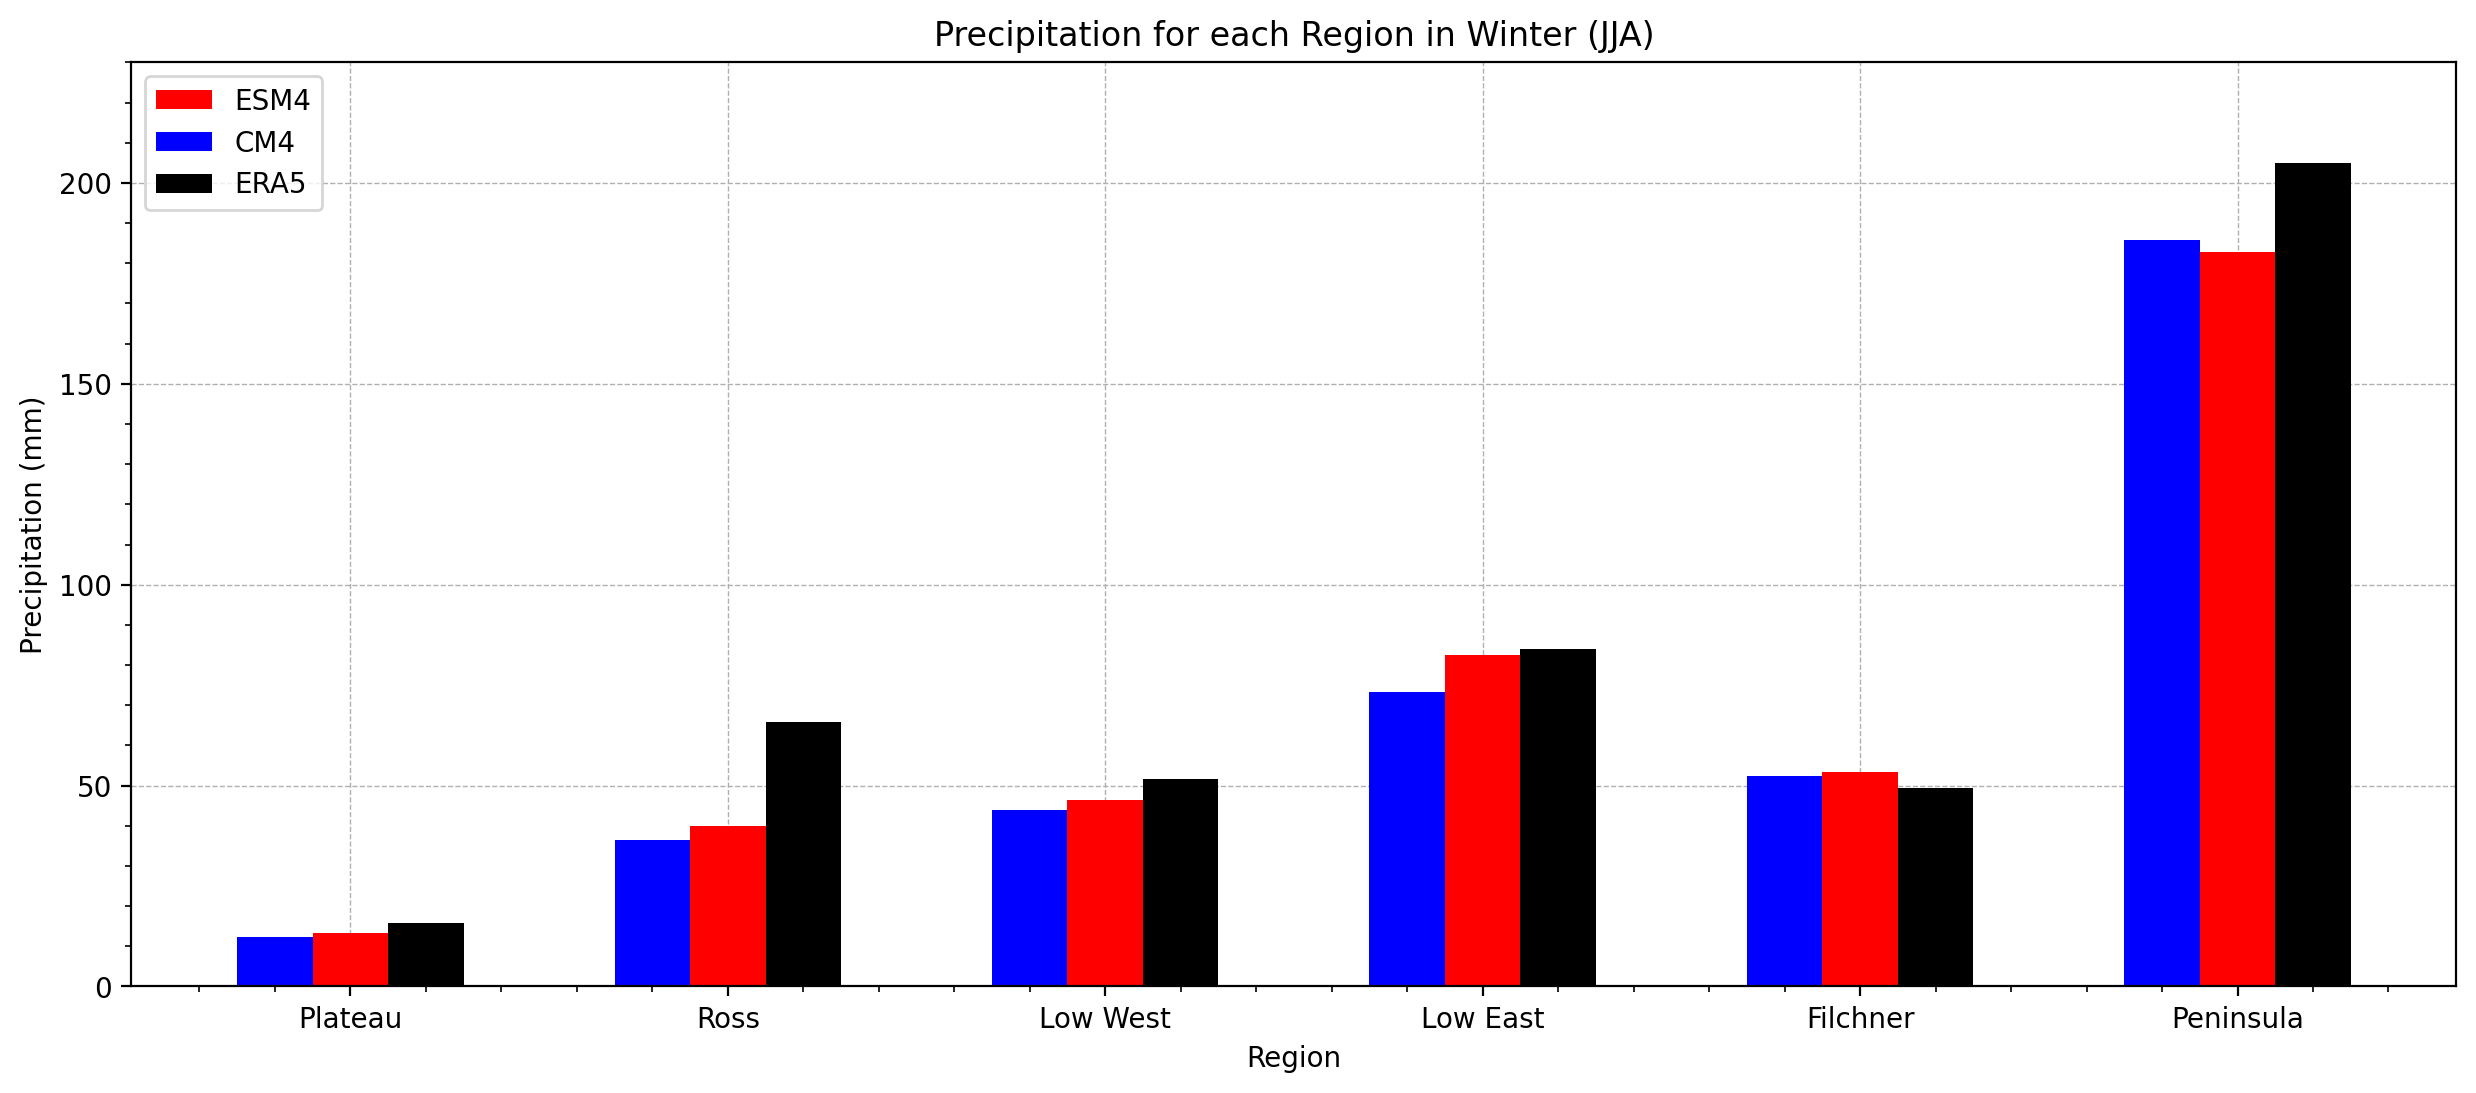

In [46]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_winter = [12.25357276853174,
36.548962199594826,
43.99865854647942,
73.22958607692271,
52.281549491453916,
185.8074198011309

] 
ESM4_winter = [13.226023520110175,
39.84396340674721,
46.408330398844555,
82.40990114863962,
53.2633695343975,
182.7209756942466
] 

ERA5_winter = [15.801985835423693,
65.77070478815585,
51.683642668649554,
83.91112043755129,
49.378193338634446,
205.07593138609082]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_winter, 0.2, label = 'ESM4', color='red') 
plt.bar(X_axis - 0.2, CM4_winter, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_winter, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Precipitation (mm)") 
plt.title("Precipitation for each Region in Winter (JJA)") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,230)
plt.show() 





# <span style="color:red">Spring Temp Plot</span>

In [47]:
plat_value_CM4_spring=print(plateau_precip_spring_CM4.values)
ross_value_CM4_spring= print(ross_precip_spring_CM4.values)
west_value_CM4_spring=print(lowwest_precip_spring_CM4.values)
east_value_CM4_spring=print(loweast_precip_spring_CM4.values)
filch_value_CM4_spring=print(filchner_precip_spring_CM4.values)
pen_value_CM4_spring=print(peninsula_precip_spring_CM4.values)

11.31678611782263
36.36464560258901
41.27067411172902
52.99435747292591
51.30173544748686
174.84348214929923


In [48]:
plat_value_ESM4_spring=print(plateau_precip_spring_ESM4.values)
ross_value_ESM4_spring= print(ross_precip_spring_ESM4.values)
west_value_ESM4_springr=print(lowwest_precip_spring_ESM4.values)
east_value_ESM4_spring=print(loweast_precip_spring_ESM4.values)
filch_value_ESM4_spring=print(filchner_precip_spring_ESM4.values)
pen_value_ESM4_spring=print(peninsula_precip_spring_ESM4.values)

12.493643375637475
37.226611528603826
43.286384086241014
59.6997124113841
54.513851209776476
175.65721585415304


In [49]:
plat_value_ERA5_spring=print(plateau_precip_spring_ERA5.values)
ross_value_ERA5_spring= print(ross_precip_spring_ERA5.values)
west_value_ERA5_springr=print(lowwest_precip_spring_ERA5.values)
east_value_ERA5_spring=print(loweast_precip_spring_ERA5.values)
filch_value_ERA5_spring=print(filchner_precip_spring_ERA5.values)
pen_value_ERA5_spring=print(peninsula_precip_spring_ERA5.values)

15.653458105225582
51.91022299550241
48.554111349221785
62.489336798898876
53.83529286336852
202.03858899185434


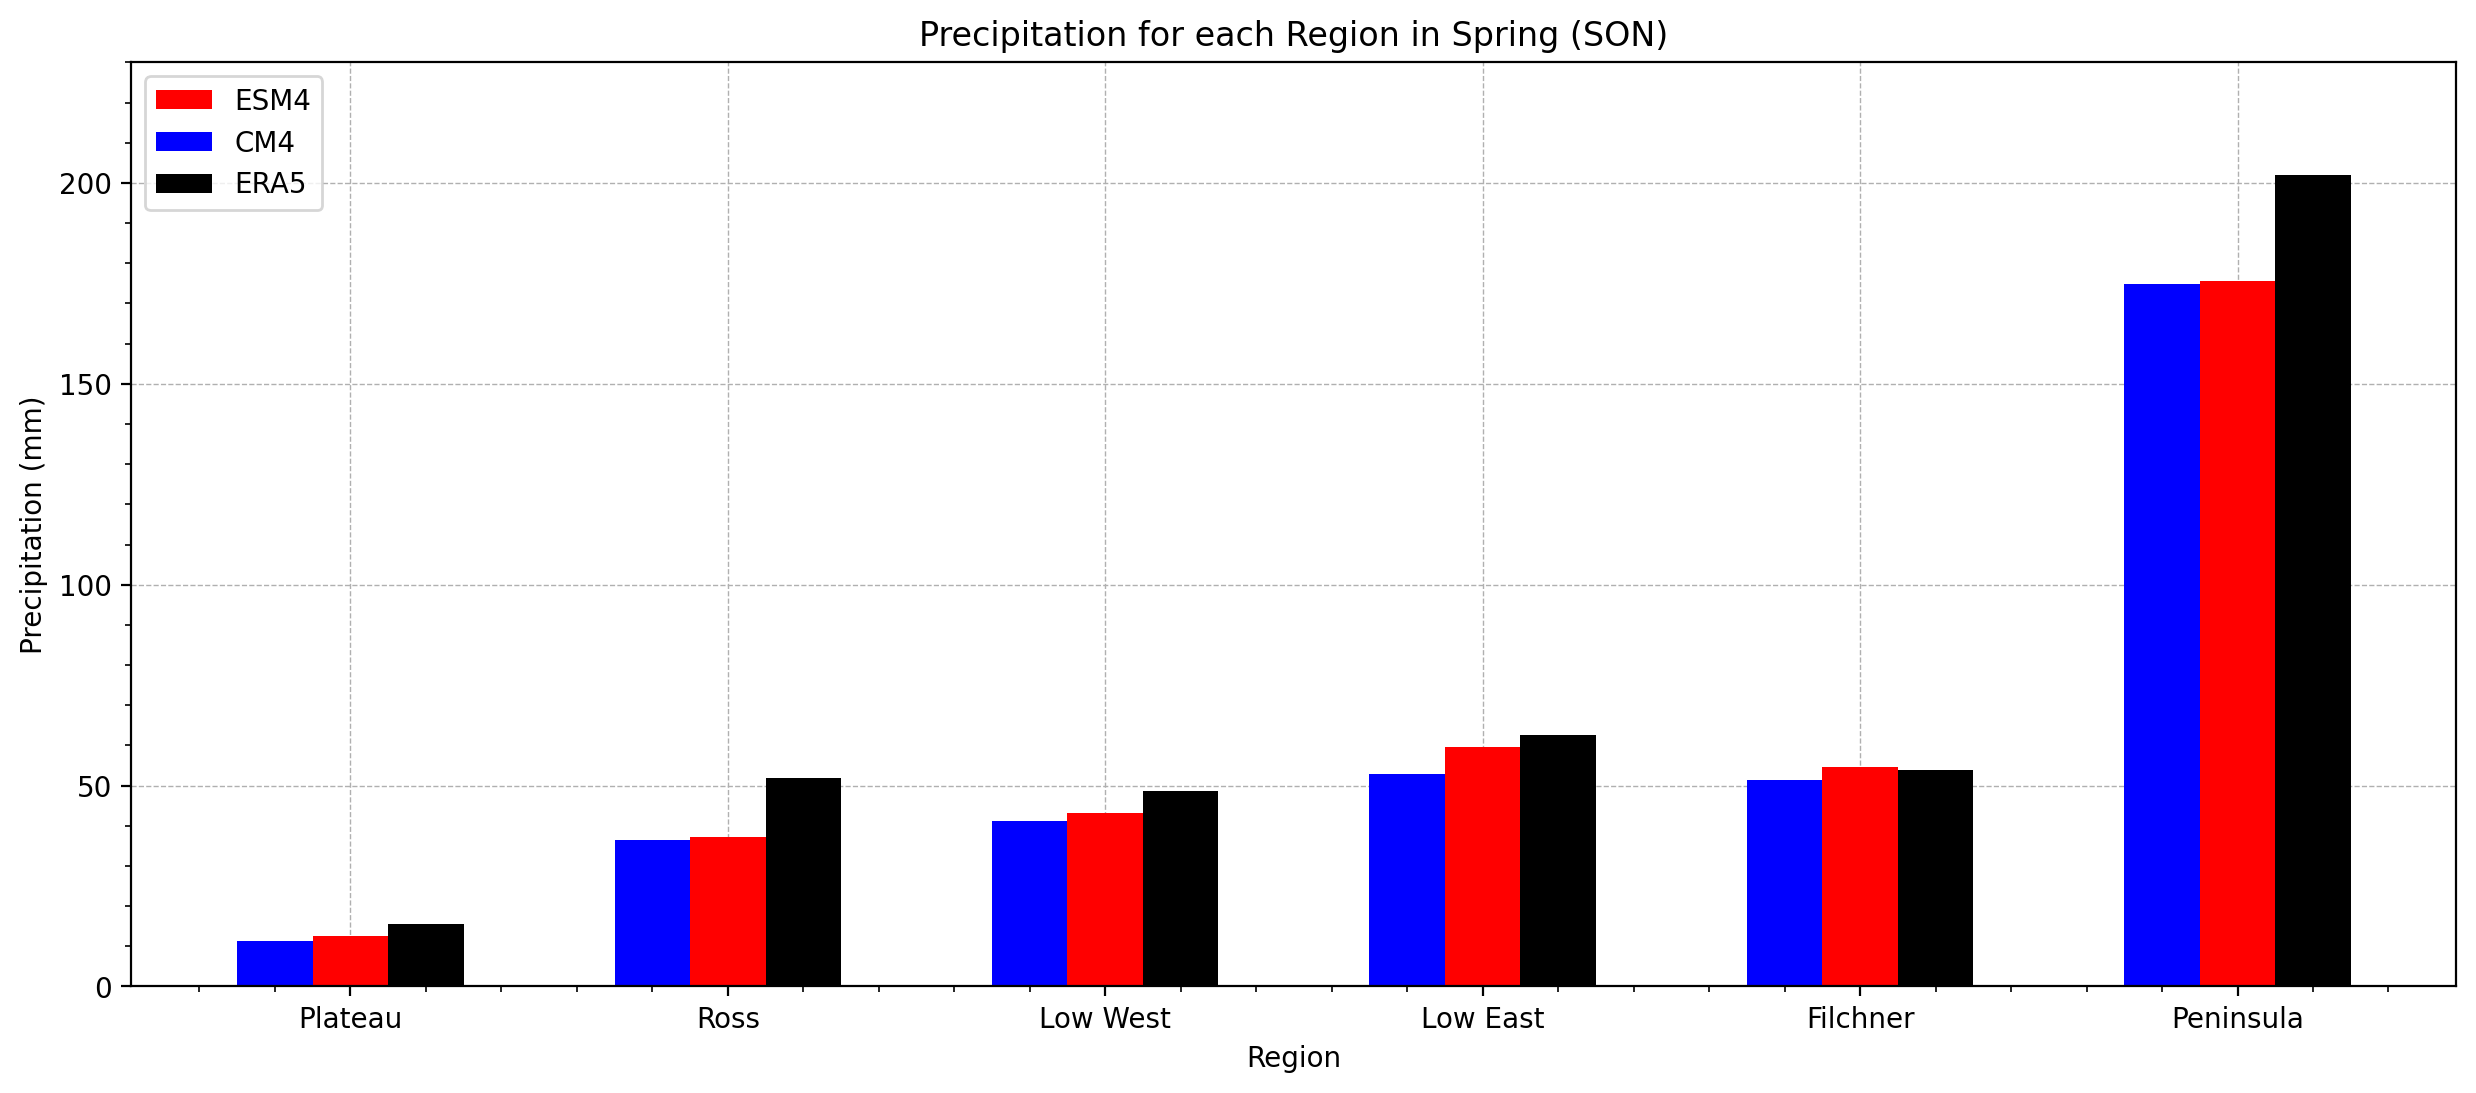

In [50]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_spring = [11.31678611782263,
36.36464560258901,
41.27067411172902,
52.99435747292591,
51.30173544748686,
174.84348214929923
] 
ESM4_spring = [12.493643375637475,
37.226611528603826,
43.286384086241014,
59.6997124113841,
54.513851209776476,
175.65721585415304
] 

ERA5_spring = [15.653458105225582,
51.91022299550241,
48.554111349221785,
62.489336798898876,
53.83529286336852,
202.03858899185434
]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_spring, 0.2, label = 'ESM4', color='r') 
plt.bar(X_axis - 0.2, CM4_spring, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_spring, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Precipitation (mm)") 
plt.title("Precipitation for each Region in Spring (SON)") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,230)
plt.show() 





# <span style="color:red">Fall Temp Plot</span>

In [51]:
plat_value_CM4_fall=print(plateau_precip_fall_CM4.values)
ross_value_CM4_fall= print(ross_precip_fall_CM4.values)
west_value_CM4_fall=print(lowwest_precip_fall_CM4.values)
east_value_CM4_fall=print(loweast_precip_fall_CM4.values)
filch_value_CM4_fall=print(filchner_precip_fall_CM4.values)
pen_value_CM4_fall=print(peninsula_precip_fall_CM4.values)

15.263988979859278
64.46923358598724
54.54630457679741
79.37792327720672
48.116606689291075
163.69516924023628


In [52]:
plat_value_ESM4_fall=print(plateau_precip_fall_ESM4.values)
ross_value_ESM4_fall= print(ross_precip_fall_ESM4.values)
west_value_ESM4_fallr=print(lowwest_precip_fall_ESM4.values)
east_value_ESM4_fall=print(loweast_precip_fall_ESM4.values)
filch_value_ESM4_fall=print(filchner_precip_fall_ESM4.values)
pen_value_ESM4_fall=print(peninsula_precip_fall_ESM4.values)

17.333490852615796
66.58975869650021
58.79087189678103
84.276775829494
53.34103127242997
168.18885777611285


In [53]:
plat_value_ERA5_fall=print(plateau_precip_fall_ERA5.values)
ross_value_ERA5_fall= print(ross_precip_fall_ERA5.values)
west_value_ERA5_fall=print(lowwest_precip_fall_ERA5.values)
east_value_ERA5_fall=print(loweast_precip_fall_ERA5.values)
filch_value_ERA5_fall=print(filchner_precip_fall_ERA5.values)
pen_value_ERA5_fall=print(peninsula_precip_fall_ERA5.values)

19.214896610355936
71.65341968648136
57.197091093985364
82.67725127516314
51.4747494016774
208.9026507223025


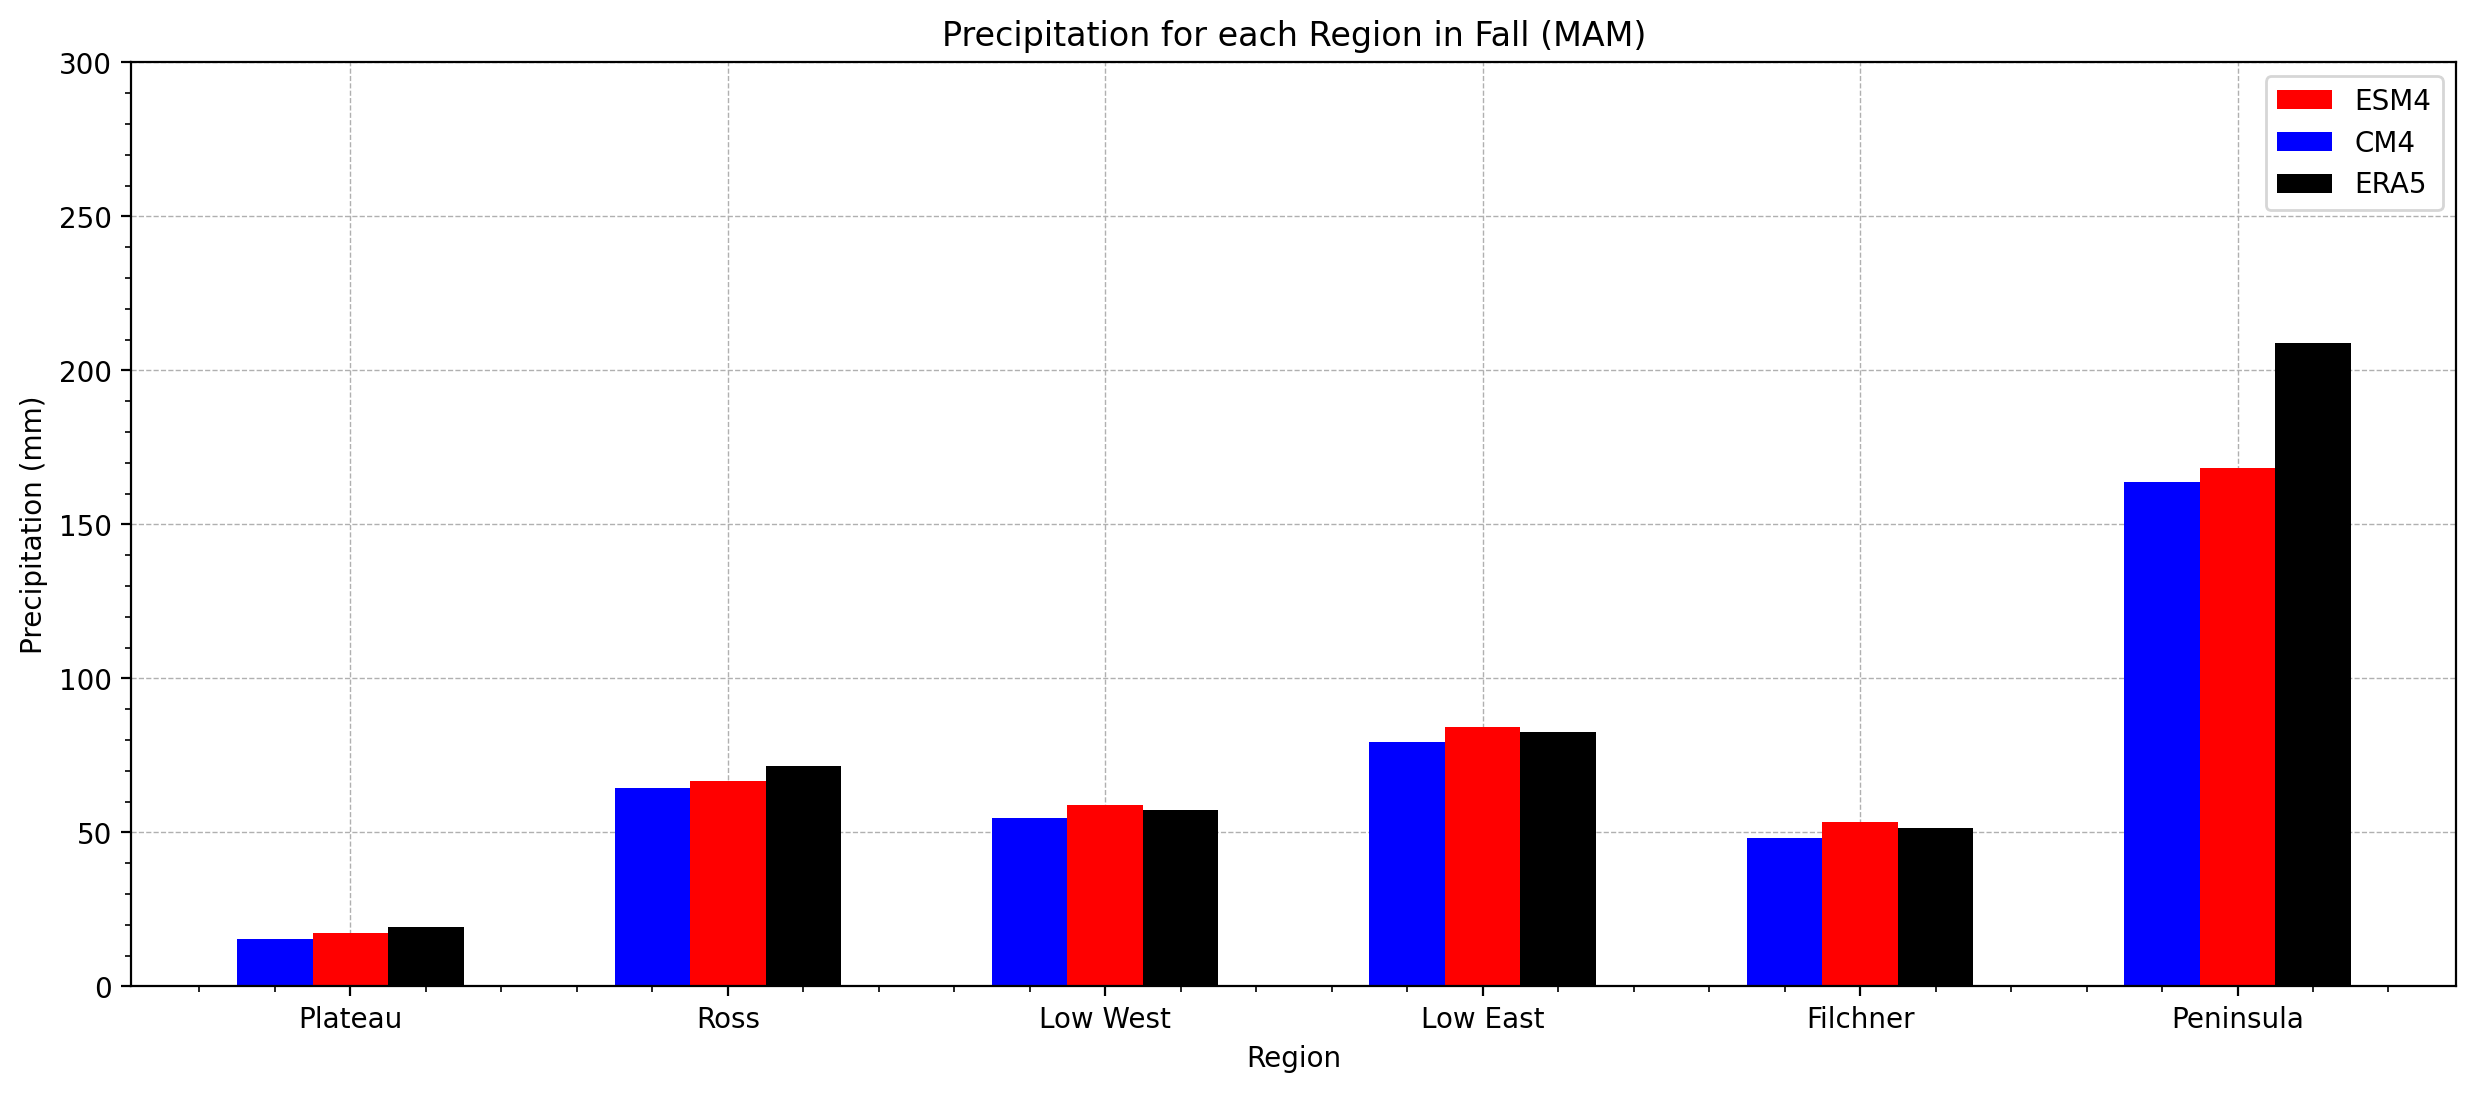

In [54]:

fig, ax= plt.subplots(figsize= (15,6))


X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4_fall = [15.263988979859278,
64.46923358598724,
54.54630457679741,
79.37792327720672,
48.116606689291075,
163.69516924023628

] 
ESM4_fall = [17.333490852615796,
66.58975869650021,
58.79087189678103,
84.276775829494,
53.34103127242997,
168.18885777611285
] 

ERA5_fall = [19.214896610355936,
71.65341968648136,
57.197091093985364,
82.67725127516314,
51.4747494016774,
208.9026507223025
]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_fall, 0.2, label = 'ESM4', color='red') 
plt.bar(X_axis - 0.2, CM4_fall, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_fall, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Precipitation (mm)") 
plt.title("Precipitation for each Region in Fall (MAM)") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,300)
plt.show() 





# <span style="color:red">Season on X Axis</span>

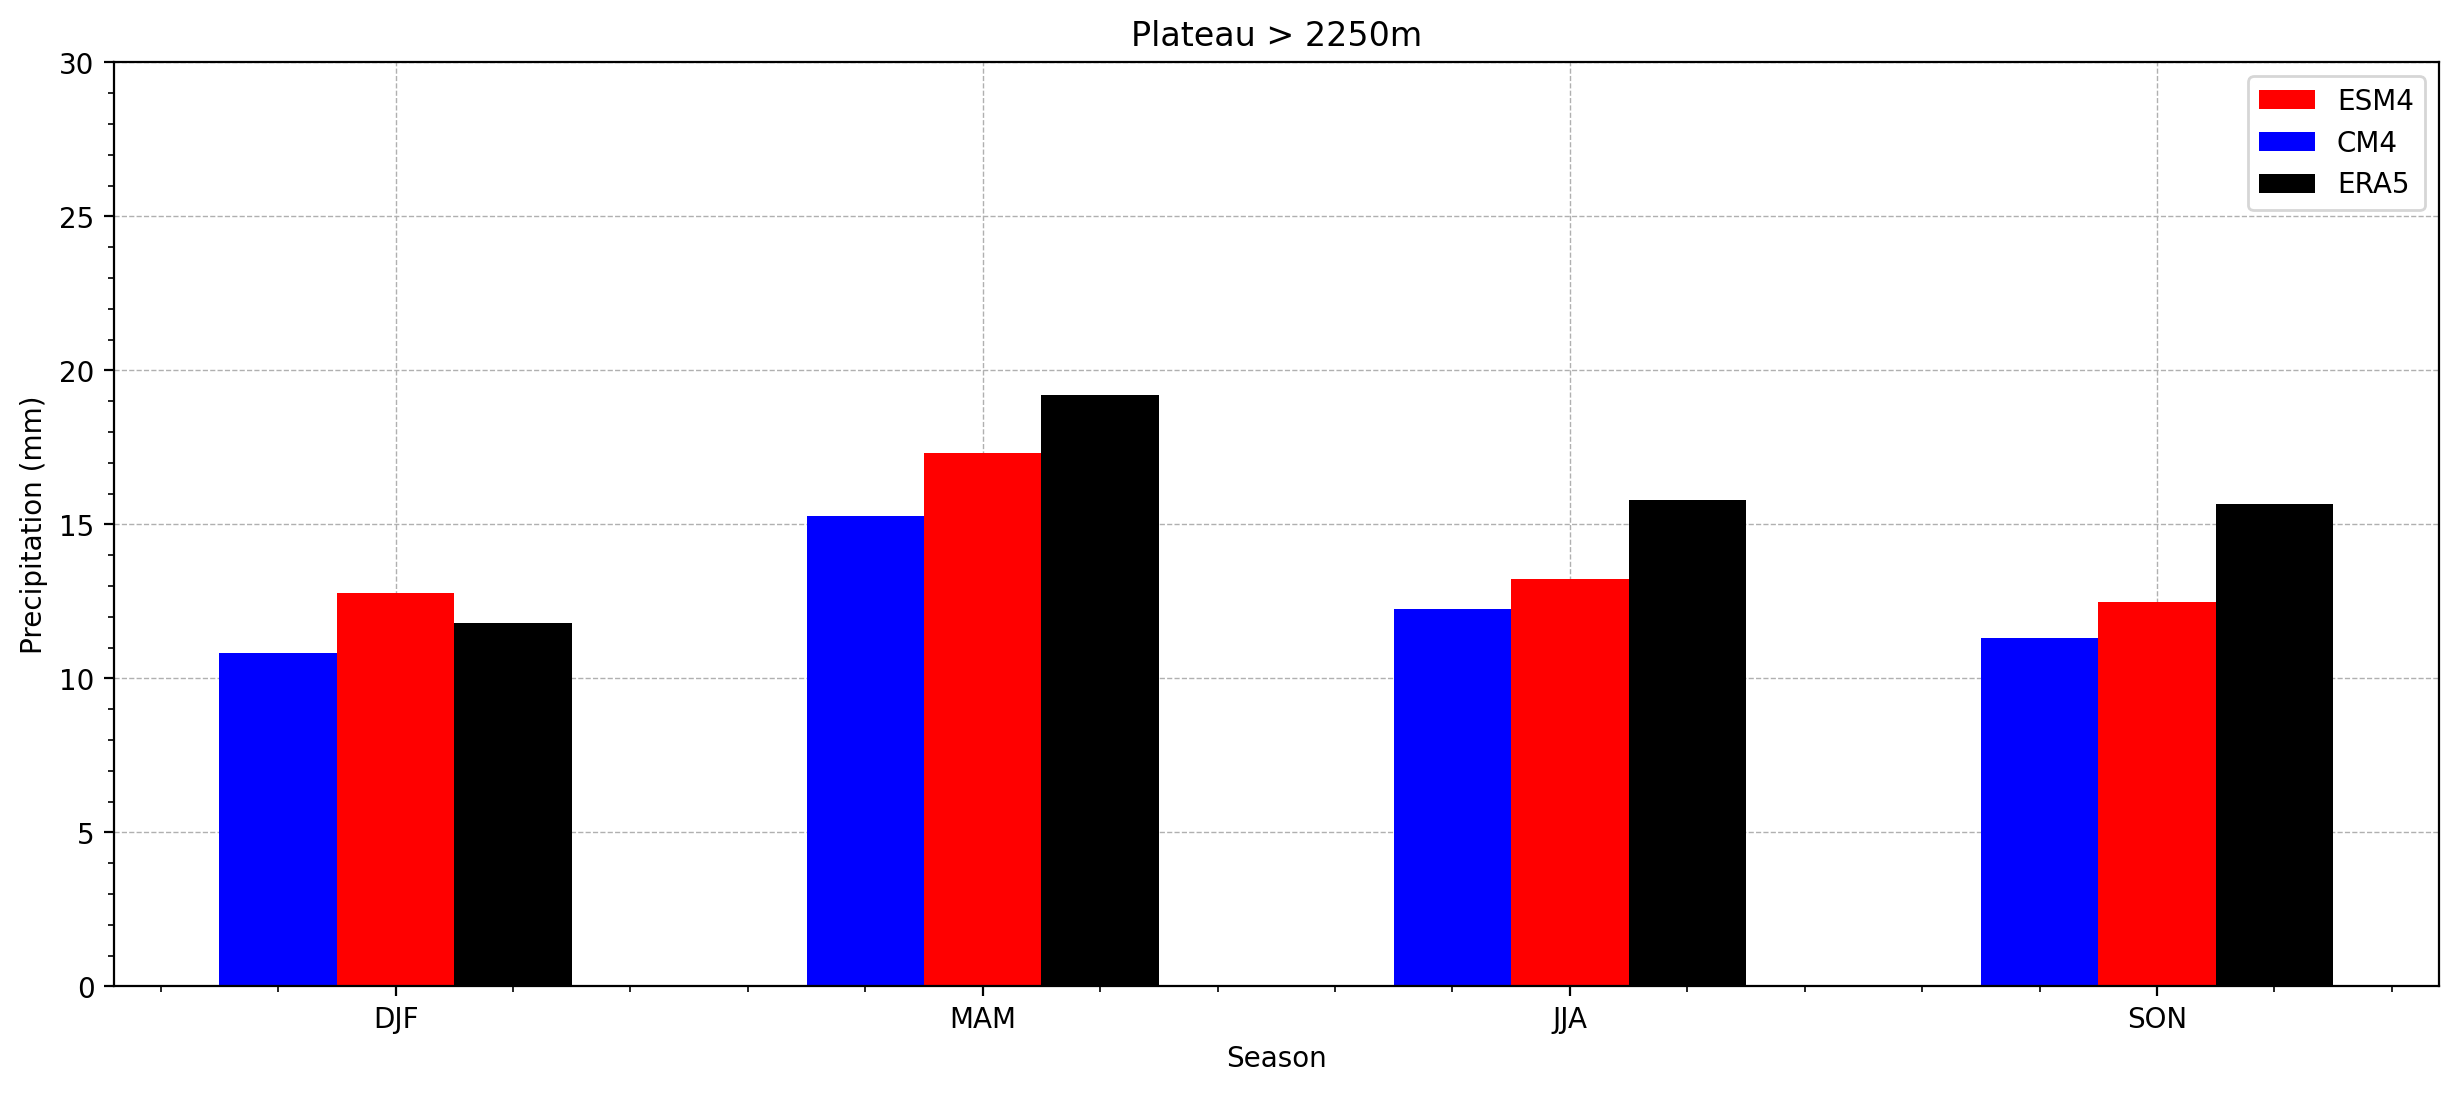

In [66]:
#plot of plateau data with season on x axis and precip on y
fig, ax= plt.subplots(figsize= (15,6))


X = ['DJF','MAM','JJA','SON'] 
CM4_all_seasons = [10.822608273883816,
                   15.263988979859278,
                   12.25357276853174,
                   11.31678611782263]
                   
                   
                   

ESM4_all_seasons = [12.789219737896929,
                    17.333490852615796,
                    13.226023520110175,
                    12.493643375637475]


ERA5_all_seasons = [11.804964116890915,
                    19.214896610355936,
                    15.801985835423693,
                    15.653458105225582]
                    
                    
                    

X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_all_seasons, 0.2, label = 'ESM4', color='red') 
plt.bar(X_axis - 0.2, CM4_all_seasons, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_all_seasons, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Season") 
plt.ylabel("Precipitation (mm)") 
plt.title("Plateau > 2250m") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,30)
plt.show() 





# <span style="color:red">Averages of lower elevations for each model</span>

In [56]:
cm4_DJF_ave= (53.18201224145014+42.626605223631486+58.57381381792948+32.05118025653064+89.50323925819248)/5
esm4_DJF_ave=(48.24368210393004+41.81621951283887+61.23524985741824+32.56126843916718+93.61944024567492)/5
era5_DJF_ave=(45.126465542125516+35.33478519238997+62.02709217905067+41.39255752670579+126.93997984752059)/5

In [57]:
cm4_DJF_ave_val=print(cm4_DJF_ave)
esm4_DJF_ave_val= print(esm4_DJF_ave)
era5_DJF_ave_val=print(era5_DJF_ave)


55.187370159546845
55.49517203180585
62.16417605755851


In [58]:
cm4_MAM_ave=(64.46923358598724+54.54630457679741+79.37792327720672+48.116606689291075+163.69516924023628)/5
esm4_MAM_ave=(66.58975869650021+58.79087189678103+84.276775829494+53.34103127242997+168.18885777611285)/5
era5_MAM_ave=(71.65341968648136+57.197091093985364+82.67725127516314+51.4747494016774+208.9026507223025)/5

In [59]:
cm4_MAM_ave_val=print(cm4_MAM_ave)
esm4_MAM_ave_val= print(esm4_MAM_ave)
era5_MAM_ave_val=print(era5_MAM_ave)

82.04104747390375
86.23745909426361
94.38103243592195


In [60]:
cm4_JJA_ave=(36.548962199594826+43.99865854647942+73.22958607692271+52.281549491453916+185.8074198011309)/5
esm4_JJA_ave=(39.84396340674721+46.408330398844555+82.40990114863962+53.2633695343975+182.7209756942466)/5
era5_JJA_ave=(65.77070478815585+51.683642668649554+83.91112043755129+49.378193338634446+205.07593138609082)/5

In [61]:
cm4_JJA_ave_val=print(cm4_JJA_ave)
esm4_JJA_ave_val= print(esm4_JJA_ave)
era5_JJA_ave_val=print(era5_JJA_ave)

78.37323522311635
80.9293080365751
91.16391852381639


In [62]:
cm4_SON_ave=(36.36464560258901+41.27067411172902+52.99435747292591+51.30173544748686+174.84348214929923)/5
esm4_SON_ave=(37.226611528603826+43.286384086241014+59.6997124113841+54.513851209776476+175.65721585415304)/5
era5_SON_ave=(51.91022299550241+48.554111349221785+62.489336798898876+53.83529286336852+202.03858899185434)/5

In [63]:
cm4_SON_ave_val=print(cm4_SON_ave)
esm4_SON_ave_val= print(esm4_SON_ave)
era5_SON_ave_val=print(era5_SON_ave)

71.35497895680601
74.07675501803169
83.76551059976919


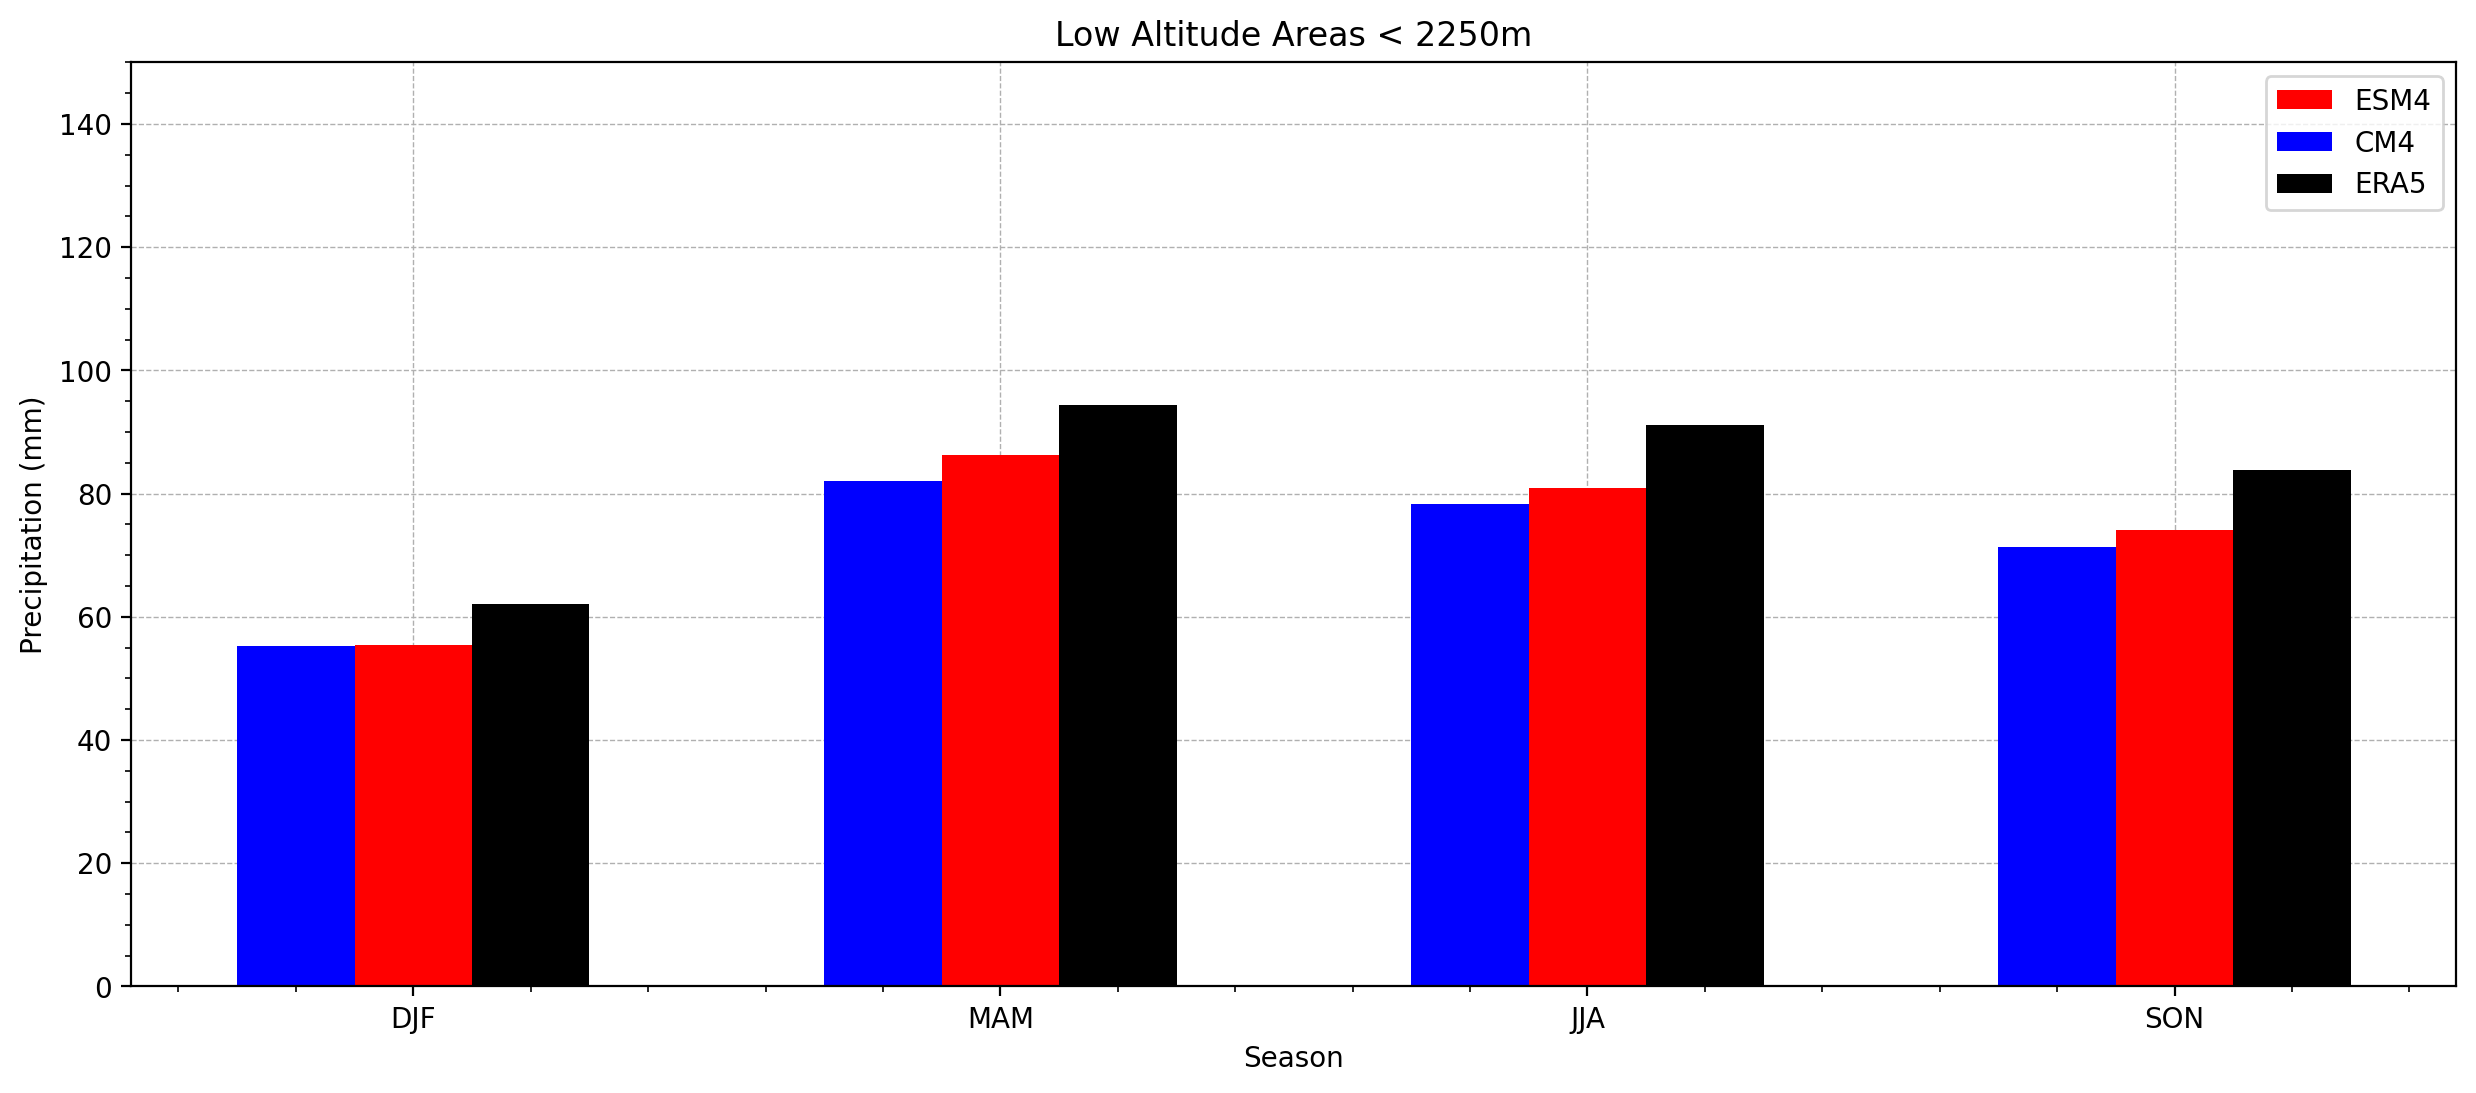

In [67]:
# averages for lower elevation with season on x axis and precip on y
fig, ax= plt.subplots(figsize= (15,6))


X = ['DJF','MAM','JJA','SON'] 
CM4_all_seasons = [55.187370159546845,
                   82.04104747390375,
                   78.37323522311635,
                   71.35497895680601
                   
                   
                   
] 
ESM4_all_seasons = [55.49517203180585,
                    86.23745909426361,
                    80.9293080365751,
                    74.07675501803169
                    
                    
] 

ERA5_all_seasons = [62.16417605755851,
                    94.38103243592195,
                    91.16391852381639,
                    83.76551059976919
                    

                    
                    
                    
]
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis, ESM4_all_seasons, 0.2, label = 'ESM4', color='red') 
plt.bar(X_axis - 0.2, CM4_all_seasons, 0.2, label = 'CM4', color= 'blue') 
plt.bar(X_axis + 0.2, ERA5_all_seasons, 0.2, label= 'ERA5', color= 'k')
ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)
plt.xticks(X_axis, X) 
plt.xlabel("Season") 
plt.ylabel("Precipitation (mm)") 
plt.title("Low Altitude Areas < 2250m") 
plt.legend() 
ax.minorticks_on()
plt.ylim(0,150)
plt.show() 



